In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loading-wordembeddings-from-txt-and-pkl-files/__results__.html
/kaggle/input/loading-wordembeddings-from-txt-and-pkl-files/__resultx__.html
/kaggle/input/loading-wordembeddings-from-txt-and-pkl-files/__notebook__.ipynb
/kaggle/input/loading-wordembeddings-from-txt-and-pkl-files/__output__.json
/kaggle/input/loading-wordembeddings-from-txt-and-pkl-files/custom.css
/kaggle/input/nlp-preprocessing-feature-extraction-methods-a-z/tokenization.py
/kaggle/input/nlp-preprocessing-feature-extraction-methods-a-z/__results__.html
/kaggle/input/nlp-preprocessing-feature-extraction-methods-a-z/__notebook__.ipynb
/kaggle/input/nlp-preprocessing-feature-extraction-methods-a-z/__output__.json
/kaggle/input/nlp-preprocessing-feature-extraction-methods-a-z/glove.6B.100d.txt.word2vec
/kaggle/input/nlp-preprocessing-feature-extraction-methods-a-z/custom.css
/kaggle/input/nlp-preprocessing-feature-extraction-methods-a-z/__pycache__/tokenization.cpython-37.pyc


In [22]:
!pip install spacy
!pip install plotly
!pip install seaborn
!pip install nltk

In [4]:
import spacy
import string
import re
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline
import matplotlib
plt.style.use("ggplot")
matplotlib.rcParams["figure.figsize"] = (10,5)
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [5]:
from keras.datasets import imdb

# Load the dataset
# num_words means keeping the top 10,000 most frequently occurring words in the training data
df = (train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)


17464789/17464789 [==============================] - 1s 0us/step


##  Prepare a DataFrame

In [6]:
from keras.preprocessing.sequence import pad_sequences
# Mapping for decoding reviews
word_index = imdb.get_word_index()
reverse_word_index = {value: key for (key, value) in word_index.items()}

# Decode the reviews
decoded_reviews = [' '.join([reverse_word_index.get(i - 3, '?') for i in data]) for data in train_data]

# Create a DataFrame
df = pd.DataFrame({'review': decoded_reviews, 'label': train_labels})


1641221/1641221 [==============================] - 1s 0us/step


## Basic DataFrame Operations

In [7]:
df.shape

(25000, 2)

In [8]:
df.head()

,review,label
0,? this film was just brilliant casting locatio...,1
1,? big hair big boobs bad music and a giant saf...,0
2,? this has to be one of the worst films of the...,0
3,? the ? ? at storytelling the traditional sort...,1
4,? worst mistake of my life br br i picked this...,0


In [9]:
df.tail()

,review,label
24995,? this is a racist movie but worthy of study a...,1
24996,? bela lugosi plays a doctor who will do anyth...,0
24997,? in a far away galaxy is a planet called ? it...,0
24998,? six degrees had me hooked i looked forward t...,1
24999,? as a big fan of the original film it's hard ...,0


In [10]:
df.info

<bound method DataFrame.info of                                                   review  label
0      ? this film was just brilliant casting locatio...      1
1      ? big hair big boobs bad music and a giant saf...      0
2      ? this has to be one of the worst films of the...      0
3      ? the ? ? at storytelling the traditional sort...      1
4      ? worst mistake of my life br br i picked this...      0
...                                                  ...    ...
24995  ? this is a racist movie but worthy of study a...      1
24996  ? bela lugosi plays a doctor who will do anyth...      0
24997  ? in a far away galaxy is a planet called ? it...      0
24998  ? six degrees had me hooked i looked forward t...      1
24999  ? as a big fan of the original film it's hard ...      0

[25000 rows x 2 columns]>

In [11]:
df.isnull().sum()

review    0
label     0
dtype: int64

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
label,25000.0,0.5,0.50001,0.0,0.0,0.5,1.0,1.0


##  Basic Analysis

In [13]:
# Number of reviews
print(f"Number of training reviews: {len(train_data)}")
print(f"Number of test reviews: {len(test_data)}")

# Checking the balance of labels
positive_train = sum(train_labels)
negative_train = len(train_labels) - positive_train
print(f"Training set - Positive reviews: {positive_train}, Negative reviews: {negative_train}")


Number of training reviews: 25000
Number of test reviews: 25000
Training set - Positive reviews: 12500, Negative reviews: 12500


##  Review Length Analysis

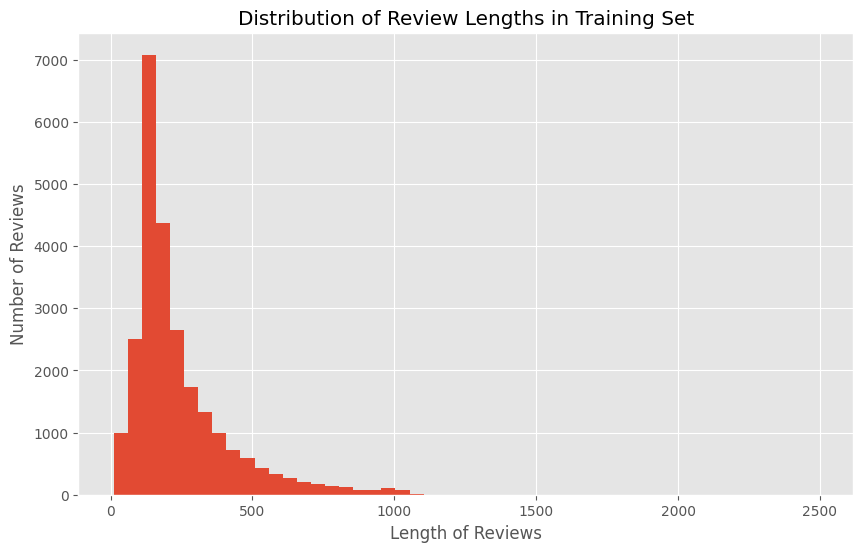

Average length of reviews: 238.71364
Minimum review length: 11
Maximum review length: 2494


In [14]:
# Length of reviews
train_lengths = [len(review) for review in train_data]

plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=50)
plt.title('Distribution of Review Lengths in Training Set')
plt.xlabel('Length of Reviews')
plt.ylabel('Number of Reviews')
plt.show()

print(f"Average length of reviews: {sum(train_lengths)/len(train_lengths)}")
print(f"Minimum review length: {min(train_lengths)}")
print(f"Maximum review length: {max(train_lengths)}")


##  Word Frequency Analysis

In [15]:
# Mapping words to integers
word_index = imdb.get_word_index()

# Reverse mapping
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Decode a review
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
print(decoded_review)


? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

## Class Distribution

In [16]:
positive = df['label'].value_counts()[1]
negative = df['label'].value_counts()[0]


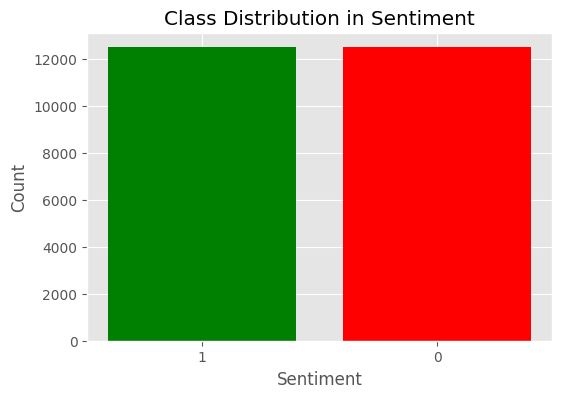

In [17]:
plt.figure(figsize=(6, 4))
plt.bar(["1", "0"], [positive, negative], color=['green', 'red'])
plt.title('Class Distribution in Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


## 2. Prepare the Data

In [18]:
df.keys()

Index(['review', 'label'], dtype='object')

In [24]:
#!python -m spacy download en_core_web_lg


## Comparative Analysis of Stop Words Across Major NLP Libraries

## Stop words in Spacy

In [20]:
# Load the SpaCy large English language model
nlp = spacy.load("en_core_web_lg")

# Get the set of English stop words
spacy_stopwords = nlp.Defaults.stop_words

print(spacy_stopwords)


{'then', 'make', 'empty', 'own', 'always', '‘re', 'by', 'thereby', 'among', 'are', 'besides', 'to', 'in', 'serious', 'a', 'still', 'via', 'myself', 'full', 'themselves', "'d", 'his', 'your', 'thereupon', 'also', "'ve", 'hence', 'her', 'more', 'n‘t', 'me', 'becomes', 'anything', 'or', 'eleven', 'so', 'mine', 'four', 're', 'been', 'neither', 'enough', 'once', 'nor', 'noone', 'within', 'can', 'though', 'give', 'together', 'onto', 'done', 'under', 'itself', 'hereby', 'three', "'m", 'call', 'has', 'take', 'himself', 'toward', 'go', 'until', 'twenty', 'yet', '’re', 'now', 'seem', '’ve', 'with', 'n’t', 'became', '’m', 'very', 'elsewhere', 'do', 'what', 'per', 'either', 'nobody', 'seems', 'thru', 'see', 'yourself', 'something', 'well', 'show', 'not', 'ten', 'becoming', 'into', 'none', 'every', 'on', 'should', 'these', 'before', 'were', 'between', 'formerly', 'no', 'five', 'him', 'several', 'i', 'somehow', 'next', 'when', 'mostly', "'re", 'six', 'few', 'further', 'would', 'herself', 'above', 'b

In [23]:
len(spacy_stopwords)

326

## Stop words in Nltk

In [25]:
import nltk

# Download the stopwords dataset
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
from nltk.corpus import stopwords

# Now you can use nltk's stopwords
nltk_stopwords = set(stopwords.words('english'))
print(nltk_stopwords)


{'any', 'yourself', 'then', 'mustn', 'both', 'own', 'not', "isn't", "weren't", "she's", 'doesn', 'having', 'through', 'into', "couldn't", 'by', 'on', 'all', 'should', "haven't", "won't", 'only', 'won', "you've", 'are', 'at', 'how', "doesn't", 'these', 'does', 'to', 'our', 'o', 'y', 'my', "you'll", 'while', 'before', 'were', 'in', 'during', 'below', 'between', 'being', "mightn't", 'most', 'aren', 'those', 'some', 'him', 'no', 'a', 'didn', "hasn't", 'myself', 'down', 'i', 'themselves', 'your', 'his', 'theirs', 'when', "didn't", 'hasn', 'there', 'other', 'her', 'more', 'me', 'don', 'them', 'just', "wasn't", 'or', 'mightn', 'hadn', 'yours', 'few', "hadn't", 'an', 'further', 'same', 'shouldn', 'who', 'weren', 'shan', "you'd", 'was', 'if', 'so', 'herself', "mustn't", 'above', 're', 'been', 'once', 'had', 'nor', 'am', 'against', 'where', 'again', 'here', 'needn', 'for', 'than', 'each', 'm', 'isn', 'is', "wouldn't", 'can', 'after', 'as', 'this', 'under', 'yourselves', 'hers', 's', 'd', 'and', 

In [27]:
len(nltk_stopwords)

179

## Stop words in Sklearn

In [28]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
sklearn_stopwords = set(ENGLISH_STOP_WORDS)
print(sklearn_stopwords)

{'any', 'along', 'then', 'eight', 'empty', 'mill', 'both', 'own', 'always', 'everywhere', 'made', 'back', 'by', 'seemed', 'thereby', 'among', 'are', 'besides', 'many', 'to', 'our', 'find', 'my', 'keep', 'whether', 'in', 'serious', 'else', 'most', 'please', 'some', 'a', 'still', 'via', 'myself', 'whither', 'full', 'themselves', 'last', 'hasnt', 'his', 'your', 'thereupon', 'part', 'also', 'twelve', 'nevertheless', 'describe', 'indeed', 'hence', 'her', 'more', 'me', 'becomes', 'anything', 'or', 'un', 'yours', 'an', 'fill', 'who', 'eleven', 'so', 'was', 'get', 'anywhere', 'amount', 'mine', 'cry', 'four', 're', 'been', 'throughout', 'neither', 'enough', 'once', 'had', 'nor', 'am', 'where', 'cant', 'noone', 'within', 'co', 'can', 'though', 'thick', 'give', 'together', 'onto', 'done', 'under', 'couldnt', 'hundred', 'although', 'yourselves', 'and', 'itself', 'hereby', 'upon', 'three', 'whereby', 'call', 'first', 'thence', 'bill', 'that', 'has', 'be', 'their', 'one', 'whoever', 'ours', 'take', 

In [29]:
len(sklearn_stopwords)

318

## Stop words in Gensim

In [30]:
from gensim.parsing.preprocessing import STOPWORDS

# Accessing the Gensim stop words set
gensim_stopwords = STOPWORDS

# converting the frozenset to a set 
gensim_stopwords_set = set(gensim_stopwords)

# Displaying the Gensim stop words
print(gensim_stopwords_set)


{'any', 'along', 'then', 'regarding', 'make', 'eight', 'empty', 'mill', 'both', 'own', 'always', 'everywhere', 'doesn', 'made', 'really', 'back', 'by', 'seemed', 'thereby', 'are', 'among', 'besides', 'many', 'does', 'to', 'our', 'find', 'my', 'keep', 'whether', 'in', 'serious', 'else', 'didn', 'used', 'some', 'please', 'most', 'still', 'via', 'a', 'myself', 'whither', 'full', 'themselves', 'last', 'hasnt', 'his', 'your', 'thereupon', 'part', 'also', 'twelve', 'nevertheless', 'describe', 'indeed', 'hence', 'her', 'more', 'me', 'becomes', 'anything', 'un', 'or', 'yours', 'an', 'fill', 'who', 'eleven', 'so', 'was', 'get', 'anywhere', 'amount', 'mine', 'cry', 'four', 're', 'been', 'throughout', 'neither', 'enough', 'once', 'had', 'nor', 'am', 'where', 'cant', 'noone', 'kg', 'within', 'co', 'can', 'though', 'thick', 'together', 'give', 'onto', 'under', 'done', 'couldnt', 'hundred', 'although', 'yourselves', 'and', 'itself', 'hereby', 'upon', 'three', 'whereby', 'call', 'first', 'thence', 'u

In [31]:
len(gensim_stopwords)


337

In [32]:
# Combining all stop words into a single set Variable
all_stopwords = set.union(sklearn_stopwords, gensim_stopwords, spacy_stopwords, nltk_stopwords)

# This will print the combined set of stop words from sklearn, gensim, spaCy, and NLTK
print(all_stopwords)


{'then', 'make', 'empty', 'mill', 'own', 'always', '‘re', 'doesn', 'by', 'thereby', 'among', 'are', 'besides', 'to', 'find', 'in', 'serious', 'aren', 'a', 'still', 'via', 'myself', 'full', 'themselves', "'d", 'hasnt', 'his', 'your', 'thereupon', 'theirs', 'also', "'ve", 'hence', 'her', 'more', 'n‘t', 'me', 'becomes', 'anything', 'or', 'un', 'eleven', 'so', "you'd", 'mine', 'cry', 'four', 're', 'been', 'neither', 'enough', 'once', 'nor', 'noone', 'isn', 'within', 'co', 'can', 'though', 'thick', 'give', 'together', 'onto', 'done', 'under', 'couldnt', 's', 'itself', 'hereby', "you're", 'three', 'll', "'m", 'call', 'bill', 'haven', 'has', 'take', 'himself', 'toward', 'ain', 'go', 'until', 'twenty', "shouldn't", 'yet', 'wasn', '’re', 've', 'now', 'seem', '’ve', 'with', 'n’t', 'became', '’m', 'very', 'elsewhere', 'do', 't', 'ma', 'what', 'per', "shan't", "that'll", 'either', 'nobody', 'seems', 'thru', 'see', 'yourself', 'something', 'well', 'show', 'not', 'ten', 'becoming', "she's", 'into', 

In [33]:
len(all_stopwords)

412

In [34]:
# # Finding the intersection of stopwords from all four libraries
common_stopwords = nltk_stopwords.intersection(sklearn_stopwords).intersection(spacy_stopwords).intersection(gensim_stopwords)

print(common_stopwords)


{'any', 'yourself', 'then', 'both', 'own', 'not', 'through', 'into', 'on', 'should', 'by', 'all', 'only', 'are', 'at', 'how', 'these', 'to', 'our', 'my', 'while', 'before', 'were', 'in', 'during', 'below', 'between', 'being', 'most', 'those', 'some', 'him', 'no', 'a', 'down', 'myself', 'i', 'themselves', 'your', 'his', 'when', 'there', 'other', 'her', 'more', 'me', 'them', 'or', 'yours', 'few', 'an', 'further', 'same', 'who', 'was', 'if', 'so', 'herself', 'above', 're', 'been', 'once', 'had', 'nor', 'am', 'against', 'where', 'again', 'here', 'for', 'than', 'each', 'is', 'can', 'after', 'as', 'this', 'under', 'yourselves', 'hers', 'and', 'itself', 'she', 'its', 'up', 'over', 'that', 'has', 'their', 'be', 'of', 'because', 'you', 'ours', 'they', 'himself', 'he', 'ourselves', 'such', 'the', 'until', 'but', 'off', 'from', 'we', 'have', 'why', 'will', 'now', 'out', 'with', 'whom', 'very', 'do', 'it', 'what', 'which', 'about', 'too'}


In [35]:
len(common_stopwords)

119

In [36]:
# Sets of stop words for each library
sklearn_stopwords_set = set(sklearn_stopwords)
gensim_stopwords_set = set(gensim_stopwords)
spacy_stopwords_set = set(spacy_stopwords)
nltk_stopwords_set = set(nltk_stopwords)  


In [38]:
# Calculating unique stop words for each library
unique_sklearn = sklearn_stopwords_set - (gensim_stopwords_set | spacy_stopwords_set | nltk_stopwords_set)
unique_gensim = gensim_stopwords_set - (sklearn_stopwords_set | spacy_stopwords_set | nltk_stopwords_set)
unique_spacy = spacy_stopwords_set - (sklearn_stopwords_set | gensim_stopwords_set | nltk_stopwords_set)
unique_nltk = nltk_stopwords_set - (sklearn_stopwords_set | gensim_stopwords_set | spacy_stopwords_set)


In [39]:
# Counting unique stop words for each library
unique_counts = {
    'Sklearn': len(unique_sklearn),
    'Gensim': len(unique_gensim),
    'SpaCy': len(unique_spacy),
    'NLTK': len(unique_nltk)
}

# Printing the counts
for library, count in unique_counts.items():
    print(f"Unique stop words in {library}: {count}")


Unique stop words in Sklearn: 0
Unique stop words in Gensim: 3
Unique stop words in SpaCy: 22
Unique stop words in NLTK: 53


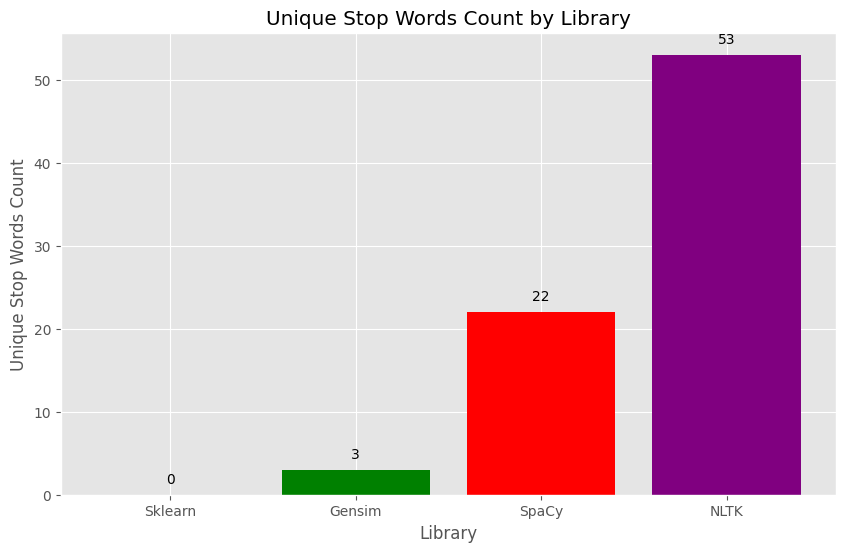

In [40]:
plt.figure(figsize=(10, 6))
bars = plt.bar(unique_counts.keys(), unique_counts.values(), color=['blue', 'green', 'red', 'purple'])

plt.title('Unique Stop Words Count by Library')
plt.xlabel('Library')
plt.ylabel('Unique Stop Words Count')

# Annotate each bar with the value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval,  # Position the text above the bar
             ha='center', va='bottom')  # Center align the text

plt.show()


##  Advanced Text Processing and Analysis

## RegEx Basics

### Using re.match()

In [41]:
import re  # Import regular expression module

pattern = r"Hello"
string = "Hello, world!"
match = re.match(pattern, string)

if match:
    print("Match found:", match.group())
else:
    print("No match")


Match found: Hello


### Using re.search()¶

In [42]:
pattern = r"world"
string = "Hello, world!"
search = re.search(pattern, string)

if search:
    print("Match found:", search.group())
else:
    print("No match")


Match found: world


### Using re.sub()¶

In [43]:
pattern = r"apples"
replacement = "bananas"
string = "I have 12 apples."
new_string = re.sub(pattern, replacement, string)

print(new_string)


I have 12 bananas.


### Character Classes

In [44]:
# Matches any single digit
re.findall("[0-9]", "Address: 123 Main Street, 456 Market Road")


['1', '2', '3', '4', '5', '6']

## Quantifiers¶

In [45]:
# Matches any word followed by one or more digits
re.findall("\w+\d+", "Room 42, Python3, PEP8")


['42', 'Python3', 'PEP8']

## Basic Spacy

In [46]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [47]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7f4fad706920>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7f4fad705f60>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7f4fb974b920>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7f4fb2cb6e00>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7f4fb7391b80>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7f4fb974bc30>)]

## Processing Text¶

### Tokenization in spacy¶

In [48]:
text100 = df['review'][100]
doc = nlp(text100)

tokens = [token.text for token in doc]
print(tokens[:20])

['?', 'i', 'am', 'a', 'great', 'fan', 'of', 'david', 'lynch', 'and', 'have', 'everything', 'that', 'he', "'s", 'made', 'on', 'dvd', 'except', 'for']


### Tokenization and part-of-speech tag.¶


In [49]:
text100 = df['review'][100]
doc = nlp(text100)

tagged = [(token.text, token.pos_) for token in doc]
print(tagged[:10])



[('?', 'PUNCT'), ('i', 'PRON'), ('am', 'AUX'), ('a', 'DET'), ('great', 'ADJ'), ('fan', 'NOUN'), ('of', 'ADP'), ('david', 'PROPN'), ('lynch', 'PROPN'), ('and', 'CCONJ')]


## Lemmatization

In [50]:
# Text with a variety of word forms
text = "The children were playing in the garden. One child found a butterfly that was sitting on a flower. They quietly approached it, hoping not to scare it away. The butterfly fluttered its wings gently before flying off into the sky."

# Process the text
doc = nlp(text)

# Iterating through each token in the document
for token in doc:
    print(token.text, " | ", token.lemma_)

The  |  the
children  |  child
were  |  be
playing  |  play
in  |  in
the  |  the
garden  |  garden
.  |  .
One  |  one
child  |  child
found  |  find
a  |  a
butterfly  |  butterfly
that  |  that
was  |  be
sitting  |  sit
on  |  on
a  |  a
flower  |  flower
.  |  .
They  |  they
quietly  |  quietly
approached  |  approach
it  |  it
,  |  ,
hoping  |  hope
not  |  not
to  |  to
scare  |  scare
it  |  it
away  |  away
.  |  .
The  |  the
butterfly  |  butterfly
fluttered  |  flutter
its  |  its
wings  |  wing
gently  |  gently
before  |  before
flying  |  fly
off  |  off
into  |  into
the  |  the
sky  |  sky
.  |  .


In [51]:
# Define the list of words
words = ["running", "runs", "ran", "runner"]

# Process the same set of words
doc = nlp(" ".join(words))

# Apply lemmatization
lemmatized_words = [token.lemma_ for token in doc]
print("Lemmatized Words:", lemmatized_words)


Lemmatized Words: ['running', 'run', 'run', 'runner']


## Customizing lemmatizer:  Named entities and their labels or information extraction

In [52]:
text = "Apple Inc. announced the iPhone 12 in California on October 13, 2020, with a starting price of $699."

doc = nlp(text)

for ent in doc.ents:
    print(ent.text, " | ", ent.label_, " | ", spacy.explain(ent.label_))


Apple Inc.  |  ORG  |  Companies, agencies, institutions, etc.
12  |  CARDINAL  |  Numerals that do not fall under another type
California  |  GPE  |  Countries, cities, states
October 13, 2020  |  DATE  |  Absolute or relative dates or periods
699  |  MONEY  |  Monetary values, including unit


In [53]:
text = "Researchers at MIT discovered a new form of carbon nanotube in 2021 that could revolutionize technology."

doc = nlp(text)

for ent in doc.ents:
    print(ent.text, " | ", ent.label_, " | ", spacy.explain(ent.label_))

MIT  |  ORG  |  Companies, agencies, institutions, etc.
2021  |  DATE  |  Absolute or relative dates or periods


In [54]:
text = "The Titanic sank in the North Atlantic Ocean on April 15, 1912, after colliding with an iceberg."

doc = nlp(text)

for ent in doc.ents:
    print(ent.text, " | ", ent.label_, " | ", spacy.explain(ent.label_))

the North Atlantic Ocean  |  LOC  |  Non-GPE locations, mountain ranges, bodies of water
April 15, 1912  |  DATE  |  Absolute or relative dates or periods


## Analyzing Word Embeddings and Vocabulary Coverage with spaCy"

In [55]:
doc = nlp("king ,queen, man, woman")
for token in doc:
    print(token.text, "Vector:", token.has_vector, "OOV:", token.is_oov)

king Vector: True OOV: False
, Vector: True OOV: False
queen Vector: True OOV: False
, Vector: True OOV: False
man Vector: True OOV: False
, Vector: True OOV: False
woman Vector: True OOV: False


In [56]:
# A sentence with technical terms
doc = nlp("biotechnology, nanomaterials, blockchain, photosynthesis")

# Iterate and print information
for token in doc:
    print(token.text, "Vector:", token.has_vector, "OOV:", token.is_oov)

biotechnology Vector: True OOV: False
, Vector: True OOV: False
nanomaterials Vector: True OOV: False
, Vector: True OOV: False
blockchain Vector: True OOV: False
, Vector: True OOV: False
photosynthesis Vector: True OOV: False


In [57]:

# Analyze proper nouns and brand names
doc = nlp("Google, Amazon, Frodo, Hogwarts")

# Iterate and print information
for token in doc:
    print(token.text, "Vector:", token.has_vector, "OOV:", token.is_oov)

Google Vector: True OOV: False
, Vector: True OOV: False
Amazon Vector: True OOV: False
, Vector: True OOV: False
Frodo Vector: True OOV: False
, Vector: True OOV: False
Hogwarts Vector: True OOV: False


### Removing Stop Words with spaCy

In [58]:
sentence1 = "This is an example of removing stop words using spaCy."
doc1 = nlp(sentence1)
filtered_sentence1 = [token.text for token in doc1 if not token.is_stop]
print("Original:", sentence1)
print("Filtered:", ' '.join(filtered_sentence1))

Original: This is an example of removing stop words using spaCy.
Filtered: example removing stop words spaCy .


In [59]:
sentence2 = "SpaCy is a free, open-source library for advanced Natural Language Processing in Python."
doc2 = nlp(sentence2)
filtered_sentence2 = [token.text for token in doc2 if not token.is_stop]
print("\nOriginal:", sentence2)
print("Filtered:", ' '.join(filtered_sentence2))


Original: SpaCy is a free, open-source library for advanced Natural Language Processing in Python.
Filtered: SpaCy free , open - source library advanced Natural Language Processing Python .


# NLTK Basics

In [60]:
import nltk

# Download the punkt tokenizer models
nltk.download('punkt')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [61]:
text50 = df['review'][50]
print(text50)

? i actually saw this movie at a theater as soon as i handed the ? my money she said two words i had never heard at a theater before or since no ? as soon as i heard those words i should have just ? bye bye to my cash and gone home but no ? i went in and watched the movie this movie didn't make anyone in the theater laugh not even once not even ? mostly we sat there in stunned silence every ten minutes or so someone would yell this movie sucks the audience would applaud ? then sit there in stunned bored silence for another ten minutes


In [62]:
tokens = nltk.word_tokenize(text50)
tokens[:10]

['?', 'i', 'actually', 'saw', 'this', 'movie', 'at', 'a', 'theater', 'as']

In [63]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('?', '.'),
 ('i', 'NN'),
 ('actually', 'RB'),
 ('saw', 'VBD'),
 ('this', 'DT'),
 ('movie', 'NN'),
 ('at', 'IN'),
 ('a', 'DT'),
 ('theater', 'NN'),
 ('as', 'RB')]

###  Text Normalization: Stemming and Lemmatization 


## Stemming in NLTK

In [64]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.stem import PorterStemmer

In [65]:
stemmer = PorterStemmer()
words = ['playing', 'played', 'plays', 'player', 'happily', 'universities', 'running', 'runner', 'explained', 'explanation', 'argue', 'argued']

# Applying stemming to each word
stemmed_words = [stemmer.stem(word) for word in words]
# Iterating through the list and stem each word
for word in words:
    print(word, "|", stemmer.stem(word))

playing | play
played | play
plays | play
player | player
happily | happili
universities | univers
running | run
runner | runner
explained | explain
explanation | explan
argue | argu
argued | argu


In [66]:
# List of words to stem
words = ["eating", "eats", "eat", "ate", "adjustable", "rafting", "ability", "meeting playing', 'played', 'plays', 'playe"]

# Iterating through the list and stem each word
for word in words:
    print(word, "|", stemmer.stem(word))


eating | eat
eats | eat
eat | eat
ate | ate
adjustable | adjust
rafting | raft
ability | abil
meeting playing', 'played', 'plays', 'playe | meeting playing', 'played', 'plays', 'play


## Removing Stop Words with NLTK

In [67]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [68]:
stop_words = set(stopwords.words('english'))

sentence1 = "This is an example of removing stop words using NLTK."
words1 = word_tokenize(sentence1)
filtered_sentence1 = [word for word in words1 if not word.lower() in stop_words]
print("Original:", sentence1)
print("Filtered:", ' '.join(filtered_sentence1))


Original: This is an example of removing stop words using NLTK.
Filtered: example removing stop words using NLTK .


In [69]:
sentence2 = "NLTK and SpaCy are the leading platform for building Python programs to work with human language data."
words2 = word_tokenize(sentence2)
filtered_sentence2 = [word for word in words2 if not word.lower() in stop_words]
print("\nOriginal:", sentence2)
print("Filtered:", ' '.join(filtered_sentence2))


Original: NLTK and SpaCy are the leading platform for building Python programs to work with human language data.
Filtered: NLTK SpaCy leading platform building Python programs work human language data .


In [38]:
#!pip install contractions
import contractions


In [73]:
sentences = [
    "You shouldn't worry too much about this.",
    "He's going to be late for the meeting.",
    "What's the matter with him?",
    "She'd like to see you now.",
    "I'd've come earlier, but I was busy.",
    "We've been thinking about moving to Canada.",
    "They're not going to accept our proposal.",
    "It's one of the best films I've seen."
]

expanded_sentences = [contractions.fix(sentence) for sentence in sentences]

# Printing original and expanded sentences
for original, expanded in zip(sentences, expanded_sentences):
    print(f"Original: {original}\nExpanded: {expanded}\n")


Original: You shouldn't worry too much about this.
Expanded: You should not worry too much about this.

Original: He's going to be late for the meeting.
Expanded: He is going to be late for the meeting.

Original: What's the matter with him?
Expanded: What is the matter with him?

Original: She'd like to see you now.
Expanded: She would like to see you now.

Original: I'd've come earlier, but I was busy.
Expanded: I would have come earlier, but I was busy.

Original: We've been thinking about moving to Canada.
Expanded: We have been thinking about moving to Canada.

Original: They're not going to accept our proposal.
Expanded: They are not going to accept our proposal.

Original: It's one of the best films I've seen.
Expanded: It is one of the best films I have seen.



## DATA CLEANING AND PRE-PROCESSING



In [74]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [39]:
# Function to clean review text using spaCy for lemmatization and stopword removal
def clean_review_with_spacy_lemmatizer_withou_stopwords(review):
    new_review = re.sub(r"'s\b", " is", review)
    new_review = re.sub("#", "", new_review)
    new_review = re.sub("@[A-Za-z0-9]+", "", new_review)
    new_review = re.sub(r"http\S+", "", new_review)
    new_review = contractions.fix(new_review)
    new_review = re.sub(r"[^a-zA-Z]", " ", new_review)
    new_review = new_review.lower().strip()

    doc = nlp(new_review)
    cleaned_review = ' '.join([token.lemma_ for token in doc if not token.is_stop])

    return cleaned_review.strip()

In [40]:
df['cleaned_review_without_stopwords'] = [clean_review_with_spacy_lemmatizer_withou_stopwords(review) for review in df['review']]


##   Cleaned_review Text and Analysis for 

In [77]:
df.head()

,review,label,cleaned_review_without_stopwords
0,? this film was just brilliant casting locatio...,1,film brilliant casting location scenery story ...
1,? big hair big boobs bad music and a giant saf...,0,big hair big boob bad music giant safety pin w...
2,? this has to be one of the worst films of the...,0,bad film s friend watch film target audie...
3,? the ? ? at storytelling the traditional sort...,1,storytelle traditional sort year event eye ...
4,? worst mistake of my life br br i picked this...,0,bad mistake life br br pick movie target fi...


In [78]:
Raw_text100 = df['review'][100]
Raw_text100

"? i am a great fan of david lynch and have everything that he's made on dvd except for hotel room the 2 hour twin peaks movie so when i found out about this i immediately grabbed it and and what is this it's a bunch of ? drawn black and white cartoons that are loud and foul mouthed and unfunny maybe i don't know what's good but maybe this is just a bunch of crap that was ? on the public under the name of david lynch to make a few bucks too let me make it clear that i didn't care about the foul language part but had to keep ? the sound because my neighbors might have all in all this is a highly disappointing release and may well have just been left in the ? box set as a curiosity i highly recommend you don't spend your money on this 2 out of 10"

In [79]:
 len(Raw_text100)

753

In [80]:
Clean_text100 = df["cleaned_review_without_stopwords"][100]
len(Clean_text100)

334

In [81]:
len(df["cleaned_review_without_stopwords"][100])

334

In [82]:
Raw_text1000 = df['review'][1000]
Raw_text1000

"? although i had seen ? in a theater way back in ? i couldn't remember anything of the plot except for vague images of kurt thomas running and fighting against a backdrop of stone walls and disappointment regarding the ending br br after reading some of the other reviews i picked up a copy of the newly released dvd to once again enter the world of ? br br it turns out this is one of those films produced during the '80s that would go directly to video today the film stars champion ? kurt thomas as jonathan ? ? out of the blue to ? the nation of ? to enter and hopefully win the game a ? ? ? by the khan who encourages his people by yelling what sounds like ? power the goal of the mission involves the star wars defense system jonathan is trained in the martial arts by princess ? who never speaks or leaves the house once trained tries to blend in with the locals by wearing a bright red ? with ? of blue and white needless to say ? finds himself running and fighting for his life along the st

In [83]:
len(Raw_text1000)

1488

In [84]:
Clean_text1000 = df["cleaned_review_without_stopwords"][1000]
Clean_text1000

'see    theater way    remember plot vague image kurt thomas run fight backdrop stone wall disappointment end br br read review pick copy newly release dvd enter world    br br turn film produce     s directly video today film star champion    kurt thomas jonathan      blue    nation    enter hopefully win game        khan encourage people yell sound like    power goal mission involve star war defense system jonathan train martial art princess    speak leave house train try blend local wear bright red       blue white needless    find run fight life stone street    way date destiny game br br star kurt thomas ill serve director robert    look like set call script incompetent review    town    good moment ultimately ruin bad edit ending       good action adventure hong kong version visceral action fast pace pretty good'

In [85]:
len(Clean_text1000)

828

In [86]:
#  collecting all words from the 'review' column
Raw_words = [word for review in df['review'] if pd.notna(review) for word in review.split()]


In [87]:
len(Raw_words)

5967762

In [88]:
#  collecting all words from the 'cleaned_review_without_stopwords' column
Clean_words = [word for review in df['cleaned_review_without_stopwords'] if pd.notna(review) for word in review.split()]


In [89]:
len(Clean_words)

2366313

## Sentiment Analysis and Tokenization Insights on Movie Reviews

In [90]:
# Tokenizing and finding the maximum length
max_length = max(len(word_tokenize(sentence)) for sentence in df["cleaned_review_without_stopwords"])
print("Maximum sentence length is:", max_length)

Maximum sentence length is: 1013


In [91]:
# Tokenizing and finding the minimum length
min_length = min(len(word_tokenize(sentence)) for sentence in df["cleaned_review_without_stopwords"])
print("Minimum sentence length is:", min_length)

Minimum sentence length is: 3


In [92]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [93]:
df.head()

,review,label,cleaned_review_without_stopwords
0,? this film was just brilliant casting locatio...,1,film brilliant casting location scenery story ...
1,? big hair big boobs bad music and a giant saf...,0,big hair big boob bad music giant safety pin w...
2,? this has to be one of the worst films of the...,0,bad film s friend watch film target audie...
3,? the ? ? at storytelling the traditional sort...,1,storytelle traditional sort year event eye ...
4,? worst mistake of my life br br i picked this...,0,bad mistake life br br pick movie target fi...


## Analyzing Sentiment Scores of Cleaned Movie Reviews

In [94]:
sia = SentimentIntensityAnalyzer()
df['scores'] = df['cleaned_review_without_stopwords'].apply(lambda review: sia.polarity_scores(review))
df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])


In [95]:
def sentiment_to_rating(compound):
    if compound > 0.6:
        return 5
    elif compound > 0.2:
        return 4
    elif compound > -0.2:
        return 3
    elif compound > -0.6:
        return 2
    else:
        return 1

df['star_rating'] = df['compound'].apply(sentiment_to_rating)


In [96]:
df.head()

,review,label,cleaned_review_without_stopwords,scores,compound,star_rating
0,? this film was just brilliant casting locatio...,1,film brilliant casting location scenery story ...,"{'neg': 0.09, 'neu': 0.409, 'pos': 0.501, 'com...",0.9937,5
1,? big hair big boobs bad music and a giant saf...,0,big hair big boob bad music giant safety pin w...,"{'neg': 0.346, 'neu': 0.403, 'pos': 0.251, 'co...",-0.9408,1
2,? this has to be one of the worst films of the...,0,bad film s friend watch film target audie...,"{'neg': 0.25, 'neu': 0.528, 'pos': 0.222, 'com...",-0.2732,2
3,? the ? ? at storytelling the traditional sort...,1,storytelle traditional sort year event eye ...,"{'neg': 0.11, 'neu': 0.616, 'pos': 0.274, 'com...",0.9899,5
4,? worst mistake of my life br br i picked this...,0,bad mistake life br br pick movie target fi...,"{'neg': 0.478, 'neu': 0.398, 'pos': 0.124, 'co...",-0.9894,1


In [97]:
for rating in sorted(df['star_rating'].unique()):  # Using .unique() to get unique star ratings and sort them
    sample_review = df[df['star_rating'] == rating].head(1)
    if not sample_review.empty:
        index_number = sample_review.index.item()
        review_text = sample_review['cleaned_review_without_stopwords'].item()  # Ensure the column name is correct
        
        # Detailed print statements for clarity
        print("--------------------------------------------------")
        print(f"Index Number: {index_number}")
        print(f"Star Rating: {rating}")
        print("Review Text:")
        print(f"'{review_text}'")
        print("--------------------------------------------------\n")


--------------------------------------------------
Index Number: 1
Star Rating: 1
Review Text:
'big hair big boob bad music giant safety pin word well describe terrible movie love cheesy horror movie see hundred get bad plot paper thin ridiculous acting abomination script completely laughable good end showdown cop work killer damn terribly write clothe sicken funny equal    hair big lot boob    man wear cut    shirt    sickening man actually wear music    trash play scene trashy music boob    take away body gym close    joke aside truly bad film charm look disaster     good old laugh bad'
--------------------------------------------------

--------------------------------------------------
Index Number: 2
Star Rating: 2
Review Text:
'bad film      s friend watch film target audience aim sat watch half hour jaw touch floor bad rest time theatre start talk leaving generally cry popcorn actually pay money    work watch feeble excuse film look like great idea paper film look like film clue

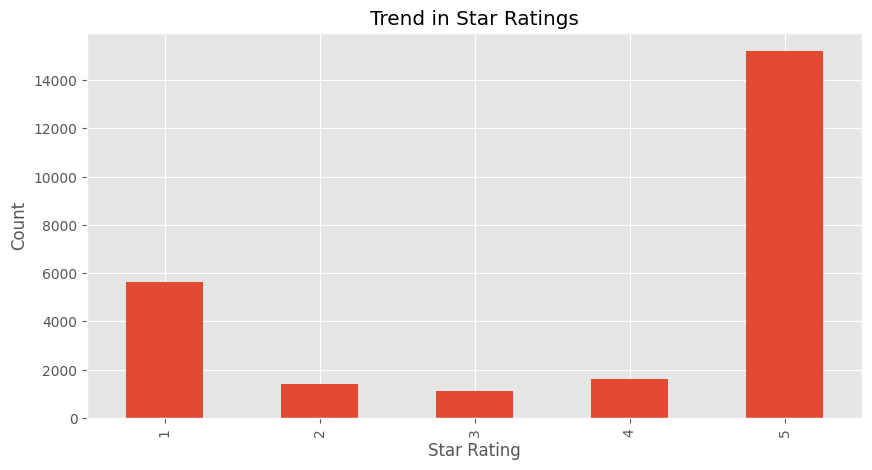

In [98]:
df['star_rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Trend in Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()


##  Data Visualization

In [99]:
# the collection all words from the 'review' column
collected_words = [word for review in df['review'] if pd.notna(review) for word in review.split()]

# Display the first 100 words in 'collected_words'
print(collected_words[:100])

# Calculate and print the number of unique words in 'collected_words'
print("Number of unique words:", len(set(collected_words)))


['?', 'this', 'film', 'was', 'just', 'brilliant', 'casting', 'location', 'scenery', 'story', 'direction', "everyone's", 'really', 'suited', 'the', 'part', 'they', 'played', 'and', 'you', 'could', 'just', 'imagine', 'being', 'there', 'robert', '?', 'is', 'an', 'amazing', 'actor', 'and', 'now', 'the', 'same', 'being', 'director', '?', 'father', 'came', 'from', 'the', 'same', 'scottish', 'island', 'as', 'myself', 'so', 'i', 'loved', 'the', 'fact', 'there', 'was', 'a', 'real', 'connection', 'with', 'this', 'film', 'the', 'witty', 'remarks', 'throughout', 'the', 'film', 'were', 'great', 'it', 'was', 'just', 'brilliant', 'so', 'much', 'that', 'i', 'bought', 'the', 'film', 'as', 'soon', 'as', 'it', 'was', 'released', 'for', '?', 'and', 'would', 'recommend', 'it', 'to', 'everyone', 'to', 'watch', 'and', 'the', 'fly', 'fishing', 'was']
Number of unique words: 9996


## Plot for Raw Reviews 


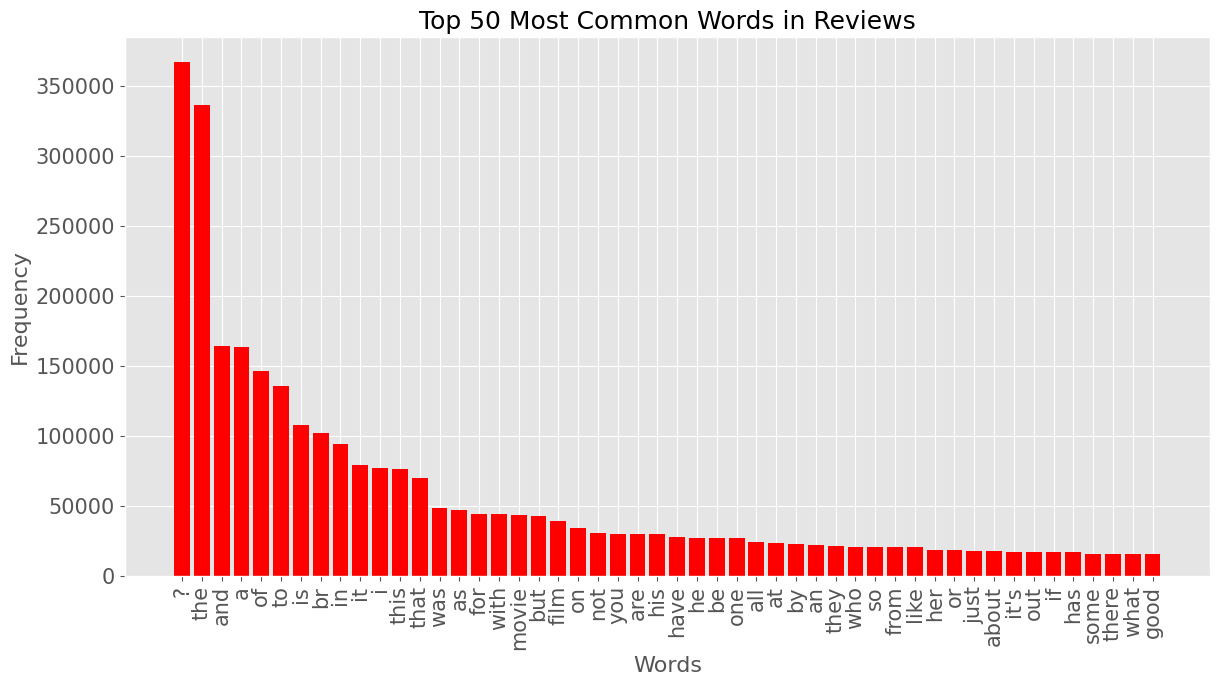

In [100]:
# Create a Frequency Distribution object
import nltk
from nltk import FreqDist
freq_dist = FreqDist(collected_words)

# Get the 50 most common words and their frequencies
most_common_words = freq_dist.most_common(50)
words, frequencies = zip(*most_common_words)  # Unpack the words and frequencies

# Create a histogram for the Top 50 most common words
plt.figure(figsize=(14, 7))
plt.bar(words, frequencies, color='red')  # Using bar instead of hist since we are plotting categorical data
plt.title('Top 50 Most Common Words in Reviews', fontsize=18)
plt.xticks(rotation=90, fontsize=15)  # Rotate x labels for better visibility
plt.yticks(fontsize=15)
plt.xlabel('Words', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.show()


## Plot for Cleaned Reviews

In [101]:
# collecting all words from all the cleaned reviews without stopwords into a single list
collected_words = [word for review in df['cleaned_review_without_stopwords'] for word in review.split()]

# Display the first 100 words in 'collected_words'
print(collected_words[:100])

# Calculate the number of unique words in 'collected_words'
unique_word_count = len(set(collected_words))
print("Number of unique words in collected_words:", unique_word_count)


['film', 'brilliant', 'casting', 'location', 'scenery', 'story', 'direction', 'suit', 'play', 'imagine', 'robert', 'amazing', 'actor', 'director', 'father', 'come', 'scottish', 'island', 'love', 'fact', 'real', 'connection', 'film', 'witty', 'remark', 'film', 'great', 'brilliant', 'buy', 'film', 'soon', 'release', 'recommend', 'watch', 'fly', 'fishing', 'amazing', 'cry', 'end', 'sad', 'know', 'cry', 'film', 'good', 'definitely', 'little', 'boy', 'play', 'norman', 'paul', 'brilliant', 'child', 'leave', 'list', 'think', 'star', 'play', 'grow', 'big', 'profile', 'film', 'child', 'amazing', 'praise', 'think', 'story', 'lovely', 'true', 'life', 'share', 'big', 'hair', 'big', 'boob', 'bad', 'music', 'giant', 'safety', 'pin', 'word', 'well', 'describe', 'terrible', 'movie', 'love', 'cheesy', 'horror', 'movie', 'see', 'hundred', 'get', 'bad', 'plot', 'paper', 'thin', 'ridiculous', 'acting', 'abomination', 'script', 'completely']
Number of unique words in collected_words: 8199


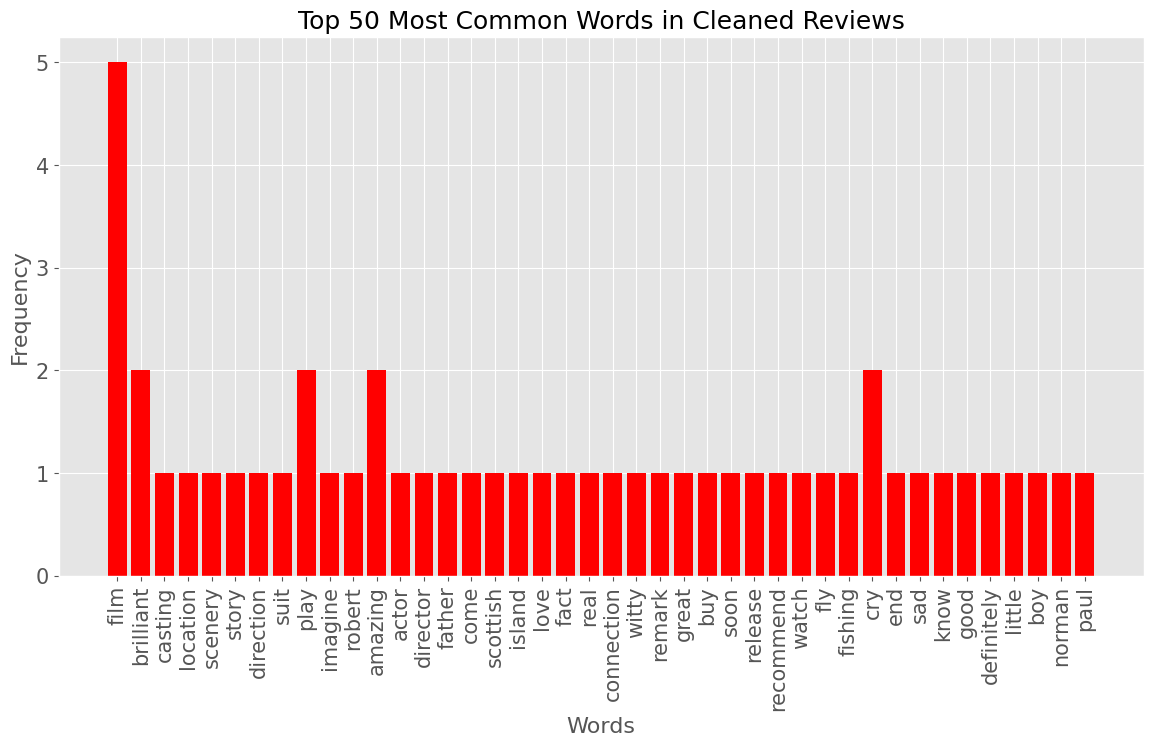

In [102]:
# Frequency Distribution of the first 50 words
freq_dist = FreqDist(collected_words[:50])

# Extract words and their frequencies
words, frequencies = zip(*freq_dist.items())  # Using items() to get both words and frequencies

# Create a bar plot for the Top 50 most common words
plt.figure(figsize=(14, 7))
plt.bar(words, frequencies, color='red')
plt.title('Top 50 Most Common Words in Cleaned Reviews', fontsize=18)
plt.xticks(rotation=90, fontsize=15)  # Rotate x labels for better visibility
plt.yticks(fontsize=15)
plt.xlabel('Words', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.show()


In [103]:
len(set(collected_words))

8199

In [104]:
# Collect words from the original 'review' column 
original_words = [word for review in df['review'] for word in review.split()]

# Collect words from the 'cleaned_review_without_stopwords' column using list comprehension
cleaned_words = [word for review in df['cleaned_review_without_stopwords'] for word in review.split()]


In [105]:
# Calculate the number of unique words in each column
unique_original_words = len(set(original_words))
unique_cleaned_words = len(set(cleaned_words))
# Calculate the difference
difference = unique_original_words - unique_cleaned_words

In [106]:

print(f"Number of unique words in original reviews: {unique_original_words}")
print(f"Number of unique words in cleaned reviews: {unique_cleaned_words}")
print(f"Difference in the number of unique words: {difference}")


Number of unique words in original reviews: 9996
Number of unique words in cleaned reviews: 8199
Difference in the number of unique words: 1797


In [107]:
from contractions import fix
#  Function to clean review text using spaCy for lemmatization and specific stopword removal
all_stopwords = set(all_stopwords).union({'?', '!', '.', ',', '-', 'br'})

def clean_review_with_csw_spacy_lemma(review, all_stopwords):
    # Expand contractions first (e.g., "don't" becomes "do not")
    review = fix(review)
    
    # Clean and remove unwanted characters and URLs
    review = re.sub(r"http\S+", "", review)  # Remove URLs
    review = re.sub(r"@[A-Za-z0-9]+", "", review)  # Remove mentions
    review = re.sub(r"[^a-zA-Z\s]", " ", review)  # Keep only alphabetic characters and spaces
    review = review.lower().strip()  # Convert to lower case and strip leading/trailing spaces
    
    # Process the cleaned text with spaCy
    doc = nlp(review)
    
    # Use list comprehension to lemmatize tokens and remove stopwords and tokens shorter than 3 characters
    cleaned_review = ' '.join([token.lemma_ for token in doc if token.text not in all_stopwords and len(token.text) > 2])
    
    return cleaned_review




In [108]:
df['cleaned_review_with/COM_stopwords'] = [clean_review_with_csw_spacy_lemma(review, all_stopwords) for review in df['review']]


In [109]:
df.head()

,review,label,cleaned_review_without_stopwords,scores,compound,star_rating,cleaned_review_with/COM_stopwords
0,? this film was just brilliant casting locatio...,1,film brilliant casting location scenery story ...,"{'neg': 0.09, 'neu': 0.409, 'pos': 0.501, 'com...",0.9937,5,film brilliant casting location scenery story ...
1,? big hair big boobs bad music and a giant saf...,0,big hair big boob bad music giant safety pin w...,"{'neg': 0.346, 'neu': 0.403, 'pos': 0.251, 'co...",-0.9408,1,big hair big boob bad music giant safety pin w...
2,? this has to be one of the worst films of the...,0,bad film s friend watch film target audie...,"{'neg': 0.25, 'neu': 0.528, 'pos': 0.222, 'com...",-0.2732,2,bad film friend watch film target audienc...
3,? the ? ? at storytelling the traditional sort...,1,storytelle traditional sort year event eye ...,"{'neg': 0.11, 'neu': 0.616, 'pos': 0.274, 'com...",0.9899,5,storytelle traditional sort year event ey...
4,? worst mistake of my life br br i picked this...,0,bad mistake life br br pick movie target fi...,"{'neg': 0.478, 'neu': 0.398, 'pos': 0.124, 'co...",-0.9894,1,bad mistake life pick movie target figure hey ...


In [110]:
# collect all words from the 'cleaned_review_with/COM_stopwords' column

collected_words = [word for review in df['cleaned_review_with/COM_stopwords'] if review for word in review.split()]

# Display the first 50 words in 'collected_words'
print("First 50 words in collected_words:", collected_words[:50])

# Calculate the number of unique words in 'collected_words'
unique_word_count = len(set(collected_words))
print("Number of unique words in collected_words:", unique_word_count)


First 50 words in collected_words: ['film', 'brilliant', 'casting', 'location', 'scenery', 'story', 'direction', 'suit', 'play', 'imagine', 'robert', 'amazing', 'actor', 'director', 'father', 'come', 'scottish', 'island', 'love', 'fact', 'real', 'connection', 'film', 'witty', 'remark', 'film', 'great', 'brilliant', 'buy', 'film', 'soon', 'release', 'recommend', 'watch', 'fly', 'fishing', 'amazing', 'cry', 'end', 'sad', 'know', 'film', 'good', 'definitely', 'little', 'boy', 'play', 'norman', 'paul', 'brilliant']
Number of unique words in collected_words: 8098


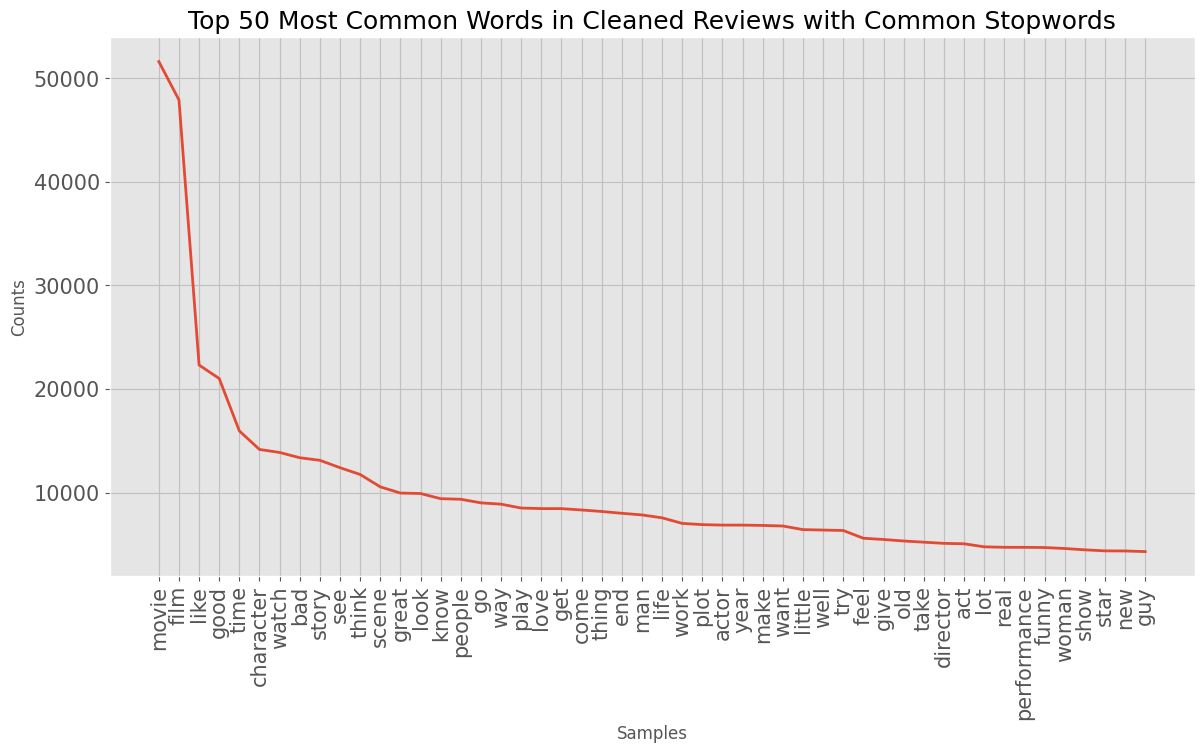

In [111]:
# Frequency Distribution
freq_dist = nltk.FreqDist(collected_words)

# Create a plot for the Top 50 most common words
plt.figure(figsize=(14,7))
plt.title('Top 50 Most Common Words in Cleaned Reviews with Common Stopwords', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Plot the frequency distribution without cumulative count
freq_dist.plot(50, cumulative=False)

plt.show()


## Feature Extractions and Model Building

In [112]:
def document_vector(doc):
    try:
        # Remove out-of-vocabulary words and get their vectors
        doc = [word for word in doc if word in model.key_to_index]
        # Obtain the vectors for each word and calculate the mean vector
        if doc:  # Check if there are any valid words in the doc
            return np.mean([model[word] for word in doc], axis=0)
        else:
            return np.zeros(model.vector_size)
    except Exception as e:
        print(f"Error processing document: {doc}")
        print(str(e))
        return np.zeros(model.vector_size)  # Return a zero vector if any error occurs
try:
    
    df['cleaned_review_with/COM_stopwords'] = [clean_review_with_csw_spacy_lemma(review, all_stopwords) for review in df['review']]
except Exception as e:
    print("Failed to apply function on DataFrame:")
    print(str(e))


In [114]:
df.head()

,review,label,cleaned_review_without_stopwords,scores,compound,star_rating,cleaned_review_with/COM_stopwords
0,? this film was just brilliant casting locatio...,1,film brilliant casting location scenery story ...,"{'neg': 0.09, 'neu': 0.409, 'pos': 0.501, 'com...",0.9937,5,film brilliant casting location scenery story ...
1,? big hair big boobs bad music and a giant saf...,0,big hair big boob bad music giant safety pin w...,"{'neg': 0.346, 'neu': 0.403, 'pos': 0.251, 'co...",-0.9408,1,big hair big boob bad music giant safety pin w...
2,? this has to be one of the worst films of the...,0,bad film s friend watch film target audie...,"{'neg': 0.25, 'neu': 0.528, 'pos': 0.222, 'com...",-0.2732,2,bad film friend watch film target audienc...
3,? the ? ? at storytelling the traditional sort...,1,storytelle traditional sort year event eye ...,"{'neg': 0.11, 'neu': 0.616, 'pos': 0.274, 'com...",0.9899,5,storytelle traditional sort year event ey...
4,? worst mistake of my life br br i picked this...,0,bad mistake life br br pick movie target fi...,"{'neg': 0.478, 'neu': 0.398, 'pos': 0.124, 'co...",-0.9894,1,bad mistake life pick movie target figure hey ...


In [115]:
def load_glove_model(glove_file):
    embeddings = {}
    with open(glove_file, 'r', encoding='utf8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = [float(val) for val in split_line[1:]]
            embeddings[word] = embedding
    return embeddings

In [116]:
# Load the GloVe model
glove_embeddings = load_glove_model('/kaggle/input/nlp-preprocessing-feature-extraction-methods-a-z/glove.6B.100d.txt.word2vec')

### 1) Countvectorizer

### 2) TF-IDF Vectorizer

In [118]:
df.head()

,review,label,cleaned_review_without_stopwords,scores,compound,star_rating,cleaned_review_with/COM_stopwords
0,? this film was just brilliant casting locatio...,1,film brilliant casting location scenery story ...,"{'neg': 0.09, 'neu': 0.409, 'pos': 0.501, 'com...",0.9937,5,film brilliant casting location scenery story ...
1,? big hair big boobs bad music and a giant saf...,0,big hair big boob bad music giant safety pin w...,"{'neg': 0.346, 'neu': 0.403, 'pos': 0.251, 'co...",-0.9408,1,big hair big boob bad music giant safety pin w...
2,? this has to be one of the worst films of the...,0,bad film s friend watch film target audie...,"{'neg': 0.25, 'neu': 0.528, 'pos': 0.222, 'com...",-0.2732,2,bad film friend watch film target audienc...
3,? the ? ? at storytelling the traditional sort...,1,storytelle traditional sort year event eye ...,"{'neg': 0.11, 'neu': 0.616, 'pos': 0.274, 'com...",0.9899,5,storytelle traditional sort year event ey...
4,? worst mistake of my life br br i picked this...,0,bad mistake life br br pick movie target fi...,"{'neg': 0.478, 'neu': 0.398, 'pos': 0.124, 'co...",-0.9894,1,bad mistake life pick movie target figure hey ...


In [117]:
df.shape

(25000, 7)

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

CV = CountVectorizer()

CV_extracted_features = CV.fit_transform(df['cleaned_review_without_stopwords'])

In [44]:
CV_extracted_features.shape

(25000, 8176)

In [121]:
CV_extracted_features[10]

<1x8176 sparse matrix of type '<class 'numpy.int64'>'
	with 124 stored elements in Compressed Sparse Row format>

In [122]:
type(CV_extracted_features[10])  # each row is a compressed spare row 

scipy.sparse._csr.csr_matrix

In [123]:
CV_extracted_features[10].todense()  # decompressing the CSR data

matrix([[0, 0, 0, ..., 0, 0, 0]])

In [124]:
df1 = pd.DataFrame(CV_extracted_features.todense() )
df1  


,0,1,2,3,4,5,6,7,8,9,...,8166,8167,8168,8169,8170,8171,8172,8173,8174,8175
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [125]:
df1.size/1e6  # it's giving you the size of df1 in terms of the number of elements, but expressed in millions. 
              #df1.size returns the total number of elements in the DataFrame, which includes both zeros and non-zero values.

204.4

In [126]:
np.count_nonzero(df1)/1e6    # np.count_nonzero(df1)/1e6: This part counts the number of non-zero elements in df1

1.790941

In [127]:
num_zeros  = df1.size/1e6 -np.count_nonzero(df1)/1e6       # since the result is too large number, 
                                                        #it indicates that df1 contains a significant number of zero elements.

In [128]:
# Calculate the total number of elements in df1
total_elements = df1.size

# Calculatin the number of non-zero elements
num_nonzero = np.count_nonzero(df1)

# Calculating the number of zero elements
num_zero = total_elements - num_nonzero

# Calculatining the percentage of zero elements
percent_zero = (num_zero / total_elements) * 100

# Calculating the percentage of non-zero elements
percent_nonzero = (num_nonzero / total_elements) * 100

# Print the results
print(f"Percentage of zero elements: {percent_zero}%")
print(f"Percentage of non-zero elements: {percent_nonzero}%")


Percentage of zero elements: 99.12380577299413%
Percentage of non-zero elements: 0.8761942270058708%


In [129]:
print(CV.get_feature_names_out()[:60])  # these are the first  sixty words of the vocabulary


['aaron' 'abandon' 'abc' 'ability' 'able' 'aboard' 'abomination'
 'abortion' 'abound' 'abraham' 'abroad' 'abrupt' 'abruptly' 'absence'
 'absent' 'absolute' 'absolutely' 'absorb' 'absorbed' 'absorbing'
 'abstract' 'absurd' 'absurdity' 'abu' 'abundance' 'abuse' 'abused'
 'abusive' 'abysmal' 'academic' 'academy' 'accent' 'accept' 'acceptable'
 'acceptance' 'accepted' 'accepting' 'access' 'accessible' 'accident'
 'accidental' 'accidentally' 'acclaim' 'acclaimed' 'accompany'
 'accompanying' 'accomplish' 'accomplished' 'accomplishment' 'accord'
 'account' 'accuracy' 'accurate' 'accurately' 'accuse' 'ace' 'achieve'
 'achieved' 'achievement' 'acid']


In [130]:
# Get the number of features

num_features = len(CV.get_feature_names_out())
print("Number of features:", num_features)


Number of features: 8176


In [131]:
CV_extracted_features.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [132]:
#  CV is the CountVectorizer instance and CV_extracted_features is the transformed data
# Accessing the word vector (feature vector) for the 21st item

word_vector_21st_review = CV_extracted_features[20]

print("Word vector of the 21st review:\n", word_vector_21st_review)


Word vector of the 21st review:
   (0, 7942)	1
  (0, 2400)	1
  (0, 529)	4
  (0, 7984)	1
  (0, 4883)	3
  (0, 64)	1
  (0, 8121)	1
  (0, 4204)	1
  (0, 4829)	1
  (0, 3616)	1
  (0, 832)	6
  (0, 7952)	1
  (0, 3319)	1
  (0, 3380)	1
  (0, 1286)	1
  (0, 6512)	1
  (0, 2779)	1
  (0, 6624)	1
  (0, 6394)	1
  (0, 5125)	1
  (0, 4984)	1
  (0, 5634)	1
  (0, 474)	1
  (0, 3713)	1
  (0, 7033)	1
  (0, 3452)	1
  (0, 5353)	1
  (0, 8084)	1
  (0, 6977)	1
  (0, 5735)	1
  (0, 6685)	1
  (0, 5207)	1
  (0, 4506)	1
  (0, 4628)	1
  (0, 6552)	1


In [133]:
df.columns

Index(['review', 'label', 'cleaned_review_without_stopwords', 'scores',
       'compound', 'star_rating', 'cleaned_review_with/COM_stopwords'],
      dtype='object')

In [134]:
#  CV is theCountVectorizer instance and CV_extracted_features is the transformed data
# Apply inverse_transform on the 41st item
actual_words_in_41st_review = CV.inverse_transform(CV_extracted_features[40])

print("Words contained in the 41st review:", actual_words_in_41st_review)


Words contained in the 41st review: [array(['film', 'father', 'island', 'great', 'soon', 'release', 'sad',
       'know', 'good', 'definitely', 'little', 'leave', 'think', 'star',
       'big', 'life', 'movie', 'see', 'get', 'plot', 'work', 'funny',
       'lot', 'man', 'close', 'charm', 'look', 'laugh', 'audience',
       'time', 'theatre', 'start', 'like', 'bit', 'year', 'character',
       'br', 'happen', 'bear', 'continue', 'pass', 'maybe', 'shortly',
       'death', 'probably', 'famous', 'age', 'mid', 'hit', 'ruin',
       'begin', 'performance', 'long', 'explain', 'help', 'right', 'find',
       'far', 'april', 'say', 'poor', 'new', 'try', 'job', 'forgettable',
       'impress', 'moment', 'second', 'show', 'problem', 'comical',
       'obviously', 'turn', 'name', 'disappoint', 'view', 'beginning',
       'daughter', 'quickly', 'kid', 'woman', 'stay', 'lead', 'town',
       'gang', 'song', 'popular', 'entire', 'later', 'experience',
       'review', 'weak', 'college', 'original', 

##  Model Building

In [135]:
df.head(2)

,review,label,cleaned_review_without_stopwords,scores,compound,star_rating,cleaned_review_with/COM_stopwords
0,? this film was just brilliant casting locatio...,1,film brilliant casting location scenery story ...,"{'neg': 0.09, 'neu': 0.409, 'pos': 0.501, 'com...",0.9937,5,film brilliant casting location scenery story ...
1,? big hair big boobs bad music and a giant saf...,0,big hair big boob bad music giant safety pin w...,"{'neg': 0.346, 'neu': 0.403, 'pos': 0.251, 'co...",-0.9408,1,big hair big boob bad music giant safety pin w...


In [142]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(CV_extracted_features, df['label'], test_size=0.25, stratify=df['label'], random_state=42)


In [143]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

def train_and_evaluate(X_train, y_train, X_test, y_test):
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'SVM': SVC(kernel='linear'),
        'Naive Bayes': MultinomialNB(),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # XGBoost specific configurations
    }
    
    # Dictionary to store the accuracy of each model
    accuracies = {}
    
    # Train each model and evaluate on test data
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Evaluate the model on training data
        train_accuracy = model.score(X_train, y_train)
        
        # Evaluate the model on testing data
        test_accuracy = model.score(X_test, y_test)
        
        # Store accuracies in the dictionary
        accuracies[model_name] = (train_accuracy, test_accuracy)
        
        # Print the results
        print(f"{model_name} trained.")
        print(f"Training Accuracy: {train_accuracy:.2%}")
        print(f"Test Accuracy: {test_accuracy:.2%}\n")
    
    return accuracies



In [144]:
# Define models dictionary
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear'),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}


def train_and_evaluate_df(X_train, y_train, X_test, y_test):
    results = []
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)
        results.append({'Model': name, 'Training Accuracy': train_acc, 'Test Accuracy': test_acc})
    
    return pd.DataFrame(results)



In [145]:
df_accuracies = train_and_evaluate_df(X_train, y_train, X_test, y_test)
print(df_accuracies)

                 Model  Training Accuracy  Test Accuracy
0  Logistic Regression           0.985547        0.85152
1                  SVM           0.994827        0.82176
2          Naive Bayes           0.869493        0.84448
3        Random Forest           0.999947        0.84032
4    Gradient Boosting           0.817227        0.79536
5              XGBoost           0.938187        0.84160


In [146]:
def train_and_evaluate_df(X_train, y_train, X_test, y_test):
    models = {
        'Logistic Regression': LogisticRegression(C=0.5, max_iter=1000),
        'SVM': SVC(kernel='linear', C=0.1),
        'Naive Bayes': MultinomialNB(),
        'Random Forest': RandomForestClassifier(n_estimators=100, max_features='sqrt', min_samples_leaf=4),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, min_samples_leaf=5),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', subsample=0.8, colsample_bytree=0.8, max_depth=3, reg_lambda=1, alpha=0.5)
    }

    results = []
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)
        results.append({'Model': name, 'Training Accuracy': train_acc, 'Test Accuracy': test_acc})
    
    return pd.DataFrame(results)


In [147]:
df_accuracies = train_and_evaluate_df(X_train, y_train, X_test, y_test)
print(df_accuracies)


                 Model  Training Accuracy  Test Accuracy
0  Logistic Regression           0.975840        0.85760
1                  SVM           0.966187        0.85536
2          Naive Bayes           0.869493        0.84448
3        Random Forest           0.938560        0.83408
4    Gradient Boosting           0.817813        0.79344
5              XGBoost           0.867573        0.83056


In [41]:
# Load a pre-trained Word2Vec model (this example uses the "word2vec-google-news-300" model)
# You can download it directly using gensim if you have an internet connection and it's not already downloaded
import gensim.downloader as api
model = api.load('word2vec-google-news-300')


In [ ]:
df['tokens'] = [review.split() for review in df['cleaned_review_with/COM_stopwords']]


In [ ]:
def document_vector(doc, model):
    """Create document vectors by averaging word vectors, ignoring words not in the model."""
    # Remove out-of-vocabulary words
    doc = [word for word in doc if word in model.key_to_index]
    if len(doc) > 0:
        # Average the remaining words' vectors
        return np.mean(model[doc], axis=0)
    else:
        # Return a zero vector if doc has no words in model vocab
        return np.zeros(model.vector_size)


In [ ]:
df['review_vectors'] = [document_vector(tokens, model) for tokens in df['tokens']]


In [ ]:
df.head(3)

In [165]:
X = np.array(df['review_vectors'].tolist())  # Converting vectors column to a suitable format
y = df['label'].values  # Target labels


In [166]:
# Splitting the dataset into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


In [167]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [164]:
def train_and_evaluate_df(X_train, y_train, X_test, y_test):
    # ApplyING MinMaxScaler for MultinomialNB and StandardScaler for other models
    scaler_standard = StandardScaler()
    scaler_min_max = MinMaxScaler()

    X_train_scaled = scaler_standard.fit_transform(X_train)
    X_test_scaled = scaler_standard.transform(X_test)
    X_train_minmax = scaler_min_max.fit_transform(X_train)
    X_test_minmax = scaler_min_max.transform(X_test)

    models = {
        'Logistic Regression': (LogisticRegression(C=0.5, max_iter=1000), X_train_scaled, X_test_scaled),
        'SVM': (SVC(kernel='linear', C=0.1), X_train_scaled, X_test_scaled),
        'Naive Bayes': (MultinomialNB(), X_train_minmax, X_test_minmax),
        'Random Forest': (RandomForestClassifier(n_estimators=100, max_features='sqrt', min_samples_leaf=4), X_train_scaled, X_test_scaled),
        'Gradient Boosting': (GradientBoostingClassifier(n_estimators=100, min_samples_leaf=5), X_train_scaled, X_test_scaled),
        'XGBoost': (xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', subsample=0.8, colsample_bytree=0.8, max_depth=3, reg_lambda=1, alpha=0.5), X_train_scaled, X_test_scaled)
    }

    results = []
    for name, (model, X_tr, X_te) in models.items():
        model.fit(X_tr, y_train)
        train_acc = model.score(X_tr, y_train)
        test_acc = model.score(X_te, y_test)
        results.append({'Model': name, 'Training Accuracy': train_acc, 'Test Accuracy': test_acc})

    return pd.DataFrame(results)



In [165]:

df_accuracies = train_and_evaluate_df(X_train, y_train, X_test, y_test)
print(df_accuracies)


                 Model  Training Accuracy  Test Accuracy
0  Logistic Regression           0.857120        0.83952
1                  SVM           0.858720        0.83856
2          Naive Bayes           0.780533        0.77136
3        Random Forest           0.995840        0.80528
4    Gradient Boosting           0.850453        0.81072
5              XGBoost           0.890400        0.82160


In [150]:
from sklearn.model_selection import cross_val_score
# Initialize scalers
scaler = StandardScaler()
    
    # Scale X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
def train_and_evaluate_df(X_train, y_train, X_test, y_test):
    models = {
        'Logistic Regression': LogisticRegression(C=0.05, max_iter=1000, penalty='l2'),
        'SVM': SVC(kernel='linear', C=0.05),
        'Naive Bayes': GaussianNB(),  
        'Random Forest': RandomForestClassifier(n_estimators=150, max_features='sqrt', min_samples_leaf=4),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, min_samples_leaf=5, subsample=0.8, max_features='sqrt'),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, subsample=0.8, colsample_bytree=0.8, max_depth=3, reg_lambda=1, alpha=0.1)
    }

    results = []
    for name, model in models.items():
        try:
            model.fit(X_train_scaled, y_train)
            train_acc = model.score(X_train_scaled, y_train)
            test_acc = model.score(X_test_scaled, y_test)
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
            results.append({
                'Model': name,
                'Training Accuracy': train_acc,
                'Test Accuracy': test_acc,
                'CV Mean Accuracy': np.mean(cv_scores),
                'CV Std Deviation': np.std(cv_scores)
            })
        except Exception as e:
            results.append({
                'Model': name,
                'Error': str(e)
            })

    return pd.DataFrame(results)




In [151]:
df_accuracies = train_and_evaluate_df(X_train, y_train, X_test, y_test)
print(df_accuracies)

                 Model  Training Accuracy  Test Accuracy  CV Mean Accuracy  \
0  Logistic Regression           0.857173        0.83984          0.846613   
1                  SVM           0.859147        0.83968          0.846987   
2          Naive Bayes           0.774507        0.76912          0.773387   
3        Random Forest           0.996000        0.80336          0.805387   
4    Gradient Boosting           0.837707        0.80624          0.810347   
5              XGBoost           0.889120        0.81456          0.822560   

   CV Std Deviation  
0          0.004095  
1          0.003881  
2          0.007140  
3          0.009418  
4          0.007241  
5          0.003993  


## Hyperparameter tunning

In [169]:
from sklearn.model_selection import cross_val_score, GridSearchCV

def train_and_evaluate_df(X_train, y_train, X_test, y_test):
    # Initialize scalers
    scaler_standard = StandardScaler()
    scaler_min_max = MinMaxScaler()

    # Scale X_train and X_test for different models
    X_train_scaled = scaler_standard.fit_transform(X_train)
    X_test_scaled = scaler_standard.transform(X_test)
    X_train_minmax = scaler_min_max.fit_transform(X_train)
    X_test_minmax = scaler_min_max.transform(X_test)

    models = {
        'Logistic Regression': (LogisticRegression(C=0.5, max_iter=1000), X_train_scaled, X_test_scaled),
        'SVM': (SVC(kernel='linear', C=0.1), X_train_scaled, X_test_scaled),
        'Naive Bayes': (MultinomialNB(), X_train_minmax, X_test_minmax),
        'Random Forest': (RandomForestClassifier(n_estimators=100, max_features='sqrt', min_samples_leaf=4), X_train_scaled, X_test_scaled),
        'Gradient Boosting': (GradientBoostingClassifier(n_estimators=100, min_samples_leaf=5), X_train_scaled, X_test_scaled),
        'XGBoost': (xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', subsample=0.8, colsample_bytree=0.8, max_depth=3, reg_lambda=1, alpha=0.5), X_train_scaled, X_test_scaled)
    }

    results = []
    for name, (model, X_tr, X_te) in models.items():
        model.fit(X_tr, y_train)
        train_acc = model.score(X_tr, y_train)
        test_acc = model.score(X_te, y_test)
        cv_scores = cross_val_score(model, X_tr, y_train, cv=5, scoring='accuracy')
        results.append({
            'Model': name,
            'Training Accuracy': train_acc,
            'Test Accuracy': test_acc,
            'CV Mean Accuracy': np.mean(cv_scores),
            'CV Std Deviation': np.std(cv_scores)
        })

    return pd.DataFrame(results)

In [167]:
def train_and_evaluate_df(X_train, y_train, X_test, y_test):
    # Initialize scalers
    scaler = StandardScaler()
    
    # Scale X_train and X_test
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Setting up the hyperparameter grids for each model using dictionaries
    param_grid = {
        'Logistic Regression': {'C': [0.01, 0.05, 0.1, 0.5, 1, 10], 'max_iter': [100, 500, 1000]},
        'SVM': {'C': [0.01, 0.05, 0.1, 0.5, 1], 'kernel': ['linear', 'rbf']},
        'Random Forest': {'n_estimators': [100, 150, 200], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 4, 10]}
    }

    # Defining the models with placeholders for hyperparameters
    models = {
        'Logistic Regression': LogisticRegression(penalty='l2'),
        'SVM': SVC(),
        'Naive Bayes': GaussianNB(),  # No hyperparameters to tune here
        'Random Forest': RandomForestClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, min_samples_leaf=5, subsample=0.8, max_features='sqrt'),  # Not tuning this for now
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, subsample=0.8, colsample_bytree=0.8, max_depth=3, reg_lambda=1, alpha=0.1)  # Not tuning this for now
    }

    results = []
    for name, model in models.items():
        if name in param_grid:
            grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='accuracy')
            grid_search.fit(X_train_scaled, y_train)
            best_model = grid_search.best_estimator_
            cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
            train_acc = best_model.score(X_train_scaled, y_train)
            test_acc = best_model.score(X_test_scaled, y_test)
            results.append({
                'Model': name,
                'Best Parameters': grid_search.best_params_,
                'Training Accuracy': train_acc,
                'Test Accuracy': test_acc,
                'CV Mean Accuracy': np.mean(cv_scores),
                'CV Std Deviation': np.std(cv_scores)
            })
        else:
            model.fit(X_train_scaled, y_train)
            train_acc = model.score(X_train_scaled, y_train)
            test_acc = model.score(X_test_scaled, y_test)
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
            results.append({
                'Model': name,
                'Training Accuracy': train_acc,
                'Test Accuracy': test_acc,
                'CV Mean Accuracy': np.mean(cv_scores),
                'CV Std Deviation': np.std(cv_scores)
            })

    return pd.DataFrame(results)

In [170]:
df_accuracies = train_and_evaluate_df(X_train, y_train, X_test, y_test)
print(df_accuracies)


                 Model  Training Accuracy  Test Accuracy  CV Mean Accuracy  \
0  Logistic Regression           0.857120        0.83952          0.846240   
1                  SVM           0.858720        0.83856          0.847093   
2          Naive Bayes           0.780533        0.77136          0.779680   
3        Random Forest           0.996107        0.79872          0.802613   
4    Gradient Boosting           0.850453        0.81072          0.812800   
5              XGBoost           0.890400        0.82160          0.823040   

   CV Std Deviation  
0          0.004590  
1          0.004074  
2          0.008410  
3          0.010665  
4          0.006274  
5          0.003620  


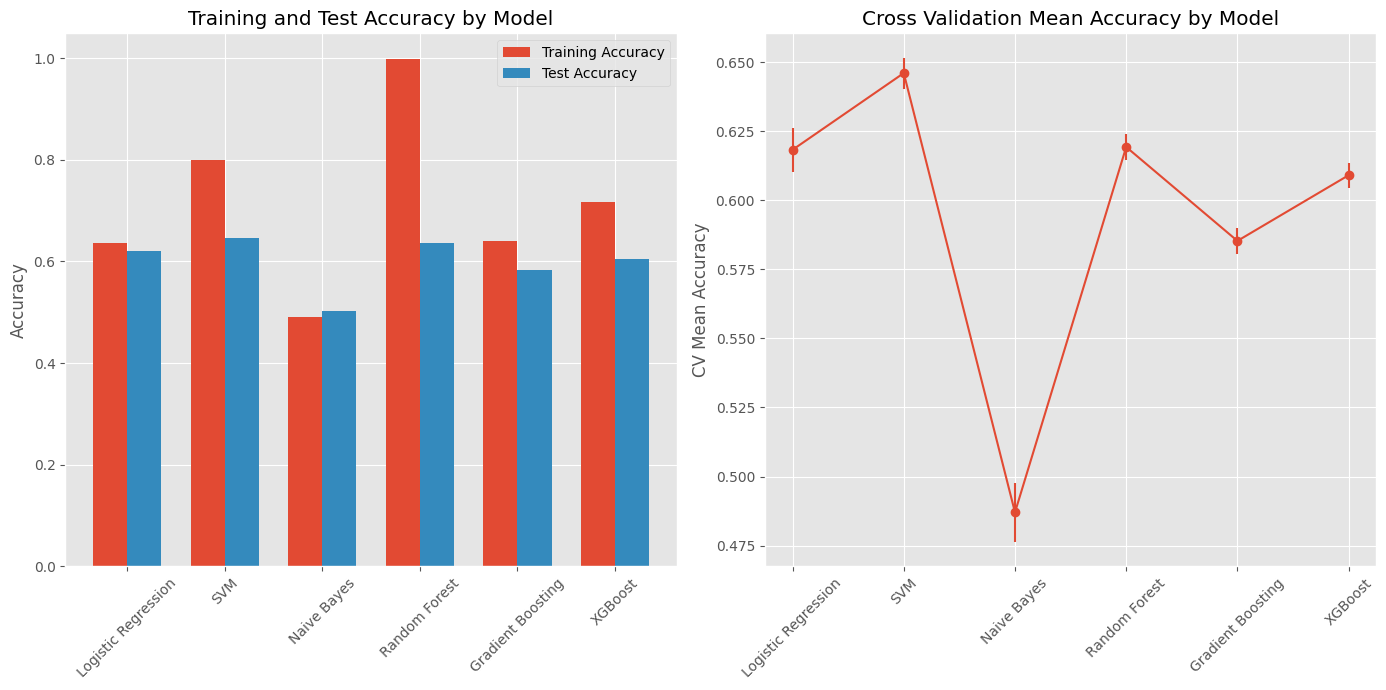

In [171]:
data = {
    'Model': ['Logistic Regression', 'SVM', 'Naive Bayes', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Training Accuracy': [0.636756, 0.799733, 0.490133, 0.998978, 0.639644, 0.716622],
    'Test Accuracy': [0.620933, 0.646000, 0.502667, 0.635733, 0.583200, 0.605467],
    'CV Mean Accuracy': [0.618267, 0.646044, 0.487022, 0.619289, 0.585289, 0.609067],
    'CV Std Deviation': [0.007966, 0.005617, 0.010768, 0.004818, 0.004592, 0.004553]
}

df_accuracies = pd.DataFrame(data)

# Setting up the matplotlib figure
plt.figure(figsize=(14, 7))

# Bar plot for Training and Test Accuracy
plt.subplot(1, 2, 1)
width = 0.35
x = df_accuracies['Model']
train_acc = df_accuracies['Training Accuracy']
test_acc = df_accuracies['Test Accuracy']

x_ind = range(len(x))  # the label locations
plt.bar(x_ind, train_acc, width, label='Training Accuracy')
plt.bar([p + width for p in x_ind], test_acc, width, label='Test Accuracy')

plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy by Model')
plt.xticks([p + width / 2 for p in x_ind], x, rotation=45)
plt.legend()

# Line plot for CV Mean Accuracy and Standard Deviation
plt.subplot(1, 2, 2)
plt.errorbar(x, df_accuracies['CV Mean Accuracy'], yerr=df_accuracies['CV Std Deviation'], fmt='-o')
plt.ylabel('CV Mean Accuracy')
plt.title('Cross Validation Mean Accuracy by Model')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


### DEEP LEARNING 

In [ ]:
df.head()

In [168]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

X = np.array(df['review_vectors'].tolist())  # Convert vectors column to a suitable format
y = df['label'].values  # Target labels


In [169]:
# Splitting the dataset into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


In [170]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [125]:
# Building the ANN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_dim=X_train.shape[1]),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # or softmax for multi-class
])


In [126]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # or categorical_crossentropy for multi-class
              metrics=['accuracy'])

In [127]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               38528     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 46849 (183.00 KB)
Trainable params: 46849 (183.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [128]:
# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/25
586/586 [==============================] - 5s 5ms/step - loss: 0.5004 - accuracy: 0.7763 - val_loss: 0.3869 - val_accuracy: 0.8365
Epoch 2/25
586/586 [==============================] - 2s 3ms/step - loss: 0.3892 - accuracy: 0.8343 - val_loss: 0.3730 - val_accuracy: 0.8400
Epoch 3/25
586/586 [==============================] - 2s 4ms/step - loss: 0.3710 - accuracy: 0.8428 - val_loss: 0.3704 - val_accuracy: 0.8389
Epoch 4/25
586/586 [==============================] - 2s 4ms/step - loss: 0.3537 - accuracy: 0.8494 - val_loss: 0.3682 - val_accuracy: 0.8387
Epoch 5/25
586/586 [==============================] - 3s 4ms/step - loss: 0.3458 - accuracy: 0.8548 - val_loss: 0.3650 - val_accuracy: 0.8389
Epoch 6/25
586/586 [==============================] - 2s 4ms/step - loss: 0.3398 - accuracy: 0.8553 - val_loss: 0.3653 - val_accuracy: 0.8411
Epoch 7/25
586/586 [==============================] - 2s 4ms/step - loss: 0.3353 - accuracy: 0.8609 - val_loss: 0.3634 - val_accuracy: 0.8421
Epoch 

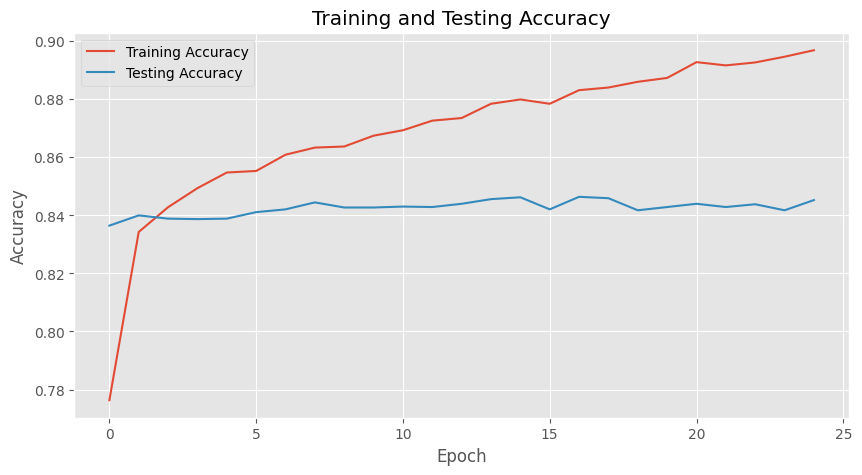

In [129]:
# Plot the training and testing accuracy and loss curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


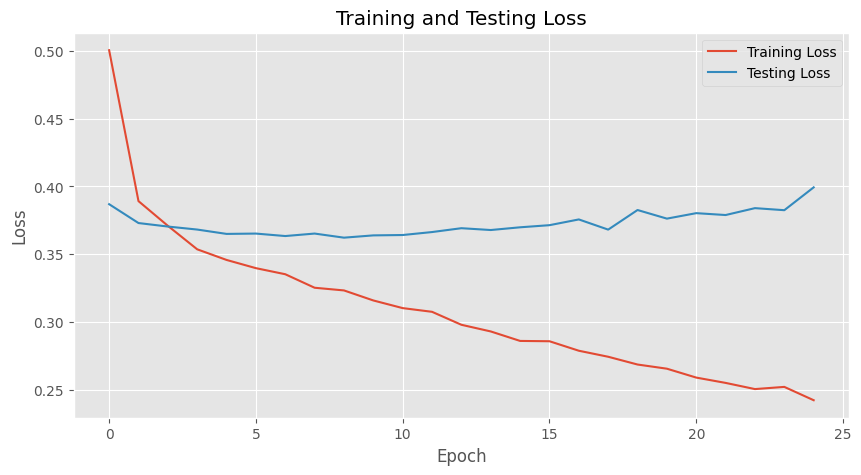

In [130]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##  Building the CNN model

In [183]:
X = np.array(df['review_vectors'].tolist())  # Convert vectors column to a suitable format
y = df['label'].values  # Target labels

# Reshape X if necessary to have a third dimension, e.g., features or channels
X = X.reshape(X.shape[0], X.shape[1], 1)

# Splitting the dataset into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Optionally scaling the features
scaler = StandardScaler()
#  reshape data to fit the scaler
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Building the CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # or softmax for multi-class
])


In [184]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # or categorical_crossentropy for multi-class
              metrics=['accuracy'])

In [185]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 298, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 149, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 147, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 73, 64)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 4672)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [186]:
# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/25
586/586 [==============================] - 13s 20ms/step - loss: 0.4733 - accuracy: 0.7775 - val_loss: 0.4373 - val_accuracy: 0.7891
Epoch 2/25
586/586 [==============================] - 12s 20ms/step - loss: 0.4043 - accuracy: 0.8235 - val_loss: 0.4085 - val_accuracy: 0.8075
Epoch 3/25
586/586 [==============================] - 11s 19ms/step - loss: 0.3843 - accuracy: 0.8364 - val_loss: 0.3727 - val_accuracy: 0.8306
Epoch 4/25
586/586 [==============================] - 12s 21ms/step - loss: 0.3772 - accuracy: 0.8398 - val_loss: 0.3763 - val_accuracy: 0.8262
Epoch 5/25
586/586 [==============================] - 11s 19ms/step - loss: 0.3669 - accuracy: 0.8436 - val_loss: 0.3765 - val_accuracy: 0.8350
Epoch 6/25
586/586 [==============================] - 11s 19ms/step - loss: 0.3614 - accuracy: 0.8467 - val_loss: 0.3742 - val_accuracy: 0.8376
Epoch 7/25
586/586 [==============================] - 11s 20ms/step - loss: 0.3537 - accuracy: 0.8483 - val_loss: 0.3721 - val_accuracy:

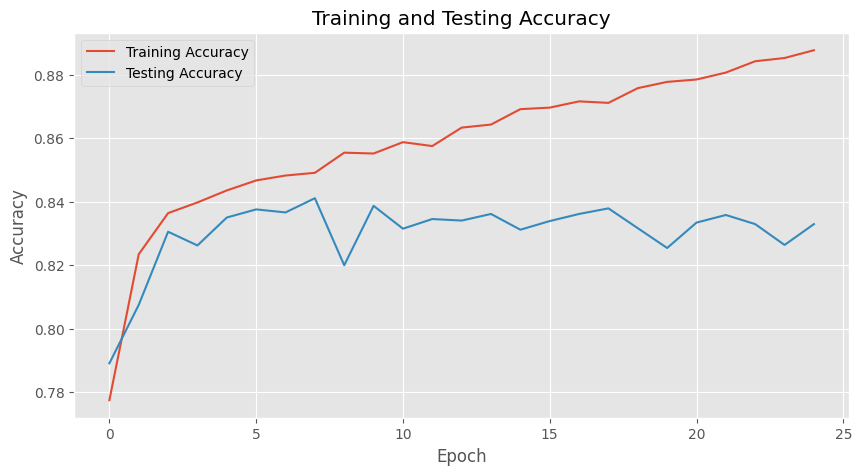

In [187]:
# Plot the training and testing accuracy and loss curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

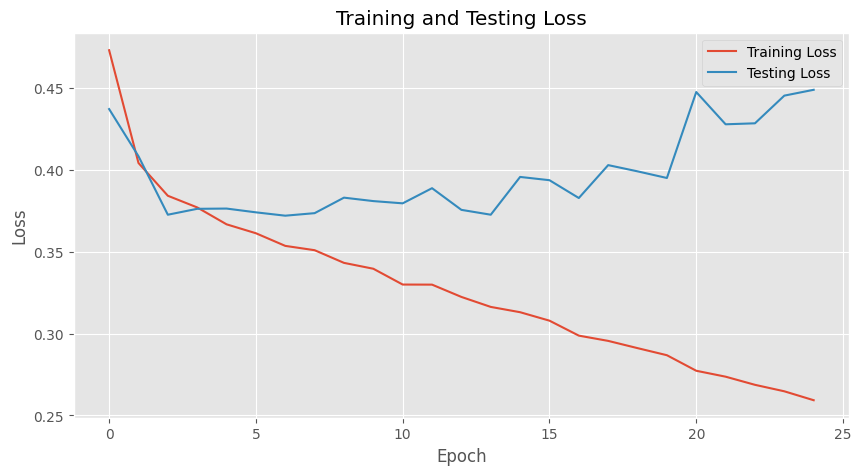

In [188]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [189]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")

196/196 - 1s - loss: 0.4491 - accuracy: 0.8330 - 1s/epoch - 6ms/step
Test Accuracy: 0.8330


In [190]:
# Save the model
model.save('cnn_model.h5')

# Save the scaler
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

## Model Deployment

In [191]:
# Custom transformer for text cleaning
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        nltk.download('punkt')
        nltk.download('stopwords')
        self.stop_words_nltk = set(stopwords.words('english'))
        self.nlp = spacy.load('en_core_web_sm')

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [self._clean_text(text) for text in X]
    
    def _clean_text(self, text):
        text = BeautifulSoup(text, "html.parser").get_text()
        text = text.lower()
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\w*\d\w*', '', text)
        text = re.sub(r'[‘’“”…]', '', text)
        text = re.sub(r'\n', ' ', text)
        tokens = word_tokenize(text)
        filtered_tokens = []
        for token in self.nlp(' '.join(tokens)):
            if token.lemma_ not in self.stop_words_nltk and not (token.is_stop or token.is_punct or token.is_digit or not token.is_alpha):
                filtered_tokens.append(token.lemma_)
        cleaned_text = ' '.join(filtered_tokens)
        return cleaned_text

# Define a function to wrap the model in a way Scikit-learn pipeline can use
class KerasModelWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self.model.predict(X)

# Load the saved model
model = tf.keras.models.load_model('cnn_model.h5')

# Load scaler
scaler = joblib.load('scaler.joblib')

# Create the pipeline
pipeline = Pipeline([
    ('cleaner', TextCleaner()),
    ('scaler', scaler),
    ('model', KerasModelWrapper(model))
])

# Save the pipeline
joblib.dump(pipeline, 'pipeline.joblib')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['pipeline.joblib']

In [ ]:
# Load the pipeline
pipeline = joblib.load('pipeline.joblib')

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    input_data = [item['text'] for item in data['input']]
    
    # Use the pipeline for preprocessing and prediction
    predictions = pipeline.transform(input_data)
    predictions = predictions.tolist()
    
    return jsonify({'predictions': predictions})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


In [ ]:
python app.py


In [ ]:
curl -X POST http://0.0.0.0:5000/predict -H "Content-Type: application/json" -d '{"input": [{"text": "This is a test review."}]}'


In [ ]:
df.head()

In [171]:

# Need to reshape data to fit the scaler
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Building the LSTM model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # or softmax for multi-class
])




In [172]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # or categorical_crossentropy for multi-class
              metrics=['accuracy'])


In [173]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300, 64)           16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 31489 (123.00 KB)
Trainable params: 31489 (123.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [174]:
# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/25
586/586 [==============================] - 186s 308ms/step - loss: 0.6739 - accuracy: 0.5777 - val_loss: 0.6666 - val_accuracy: 0.5923
Epoch 2/25
586/586 [==============================] - 184s 313ms/step - loss: 0.6626 - accuracy: 0.6011 - val_loss: 0.6612 - val_accuracy: 0.6029
Epoch 3/25
586/586 [==============================] - 178s 304ms/step - loss: 0.6625 - accuracy: 0.6056 - val_loss: 0.6632 - val_accuracy: 0.5974
Epoch 4/25
586/586 [==============================] - 179s 305ms/step - loss: 0.6648 - accuracy: 0.5967 - val_loss: 0.6637 - val_accuracy: 0.5978
Epoch 5/25
586/586 [==============================] - 185s 316ms/step - loss: 0.6642 - accuracy: 0.5978 - val_loss: 0.6618 - val_accuracy: 0.5962
Epoch 6/25
586/586 [==============================] - 185s 315ms/step - loss: 0.6629 - accuracy: 0.6028 - val_loss: 0.6590 - val_accuracy: 0.6003
Epoch 7/25
586/586 [==============================] - 186s 317ms/step - loss: 0.6605 - accuracy: 0.6090 - val_loss: 0.6596 -

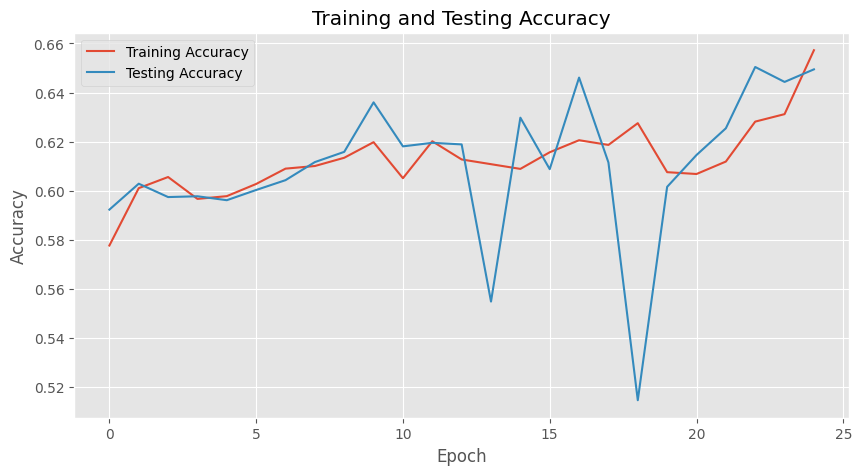

In [176]:
# Plot the training and testing accuracy and loss curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

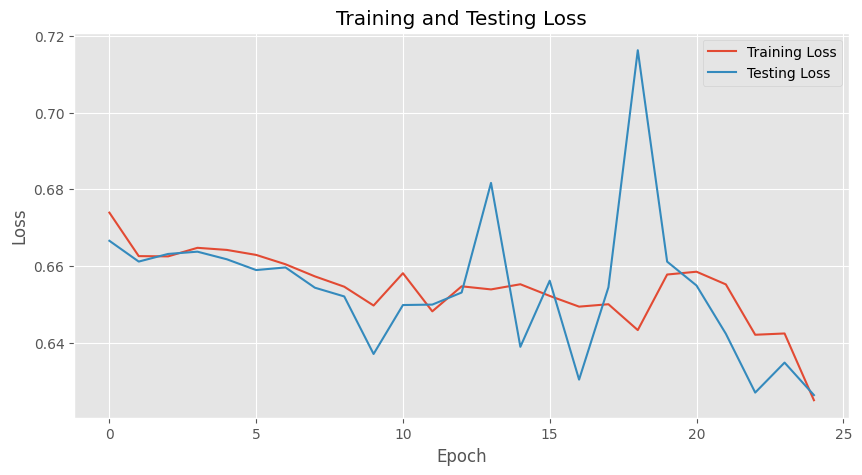

In [177]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [215]:
df.head()

,review,label,cleaned_review_without_stopwords,scores,compound,star_rating,cleaned_review_with/COM_stopwords,tokens,review_vectors
0,? this film was just brilliant casting locatio...,1,film brilliant casting location scenery story ...,"{'neg': 0.09, 'neu': 0.409, 'pos': 0.501, 'com...",0.9937,5,film brilliant casting location scenery story ...,"[film, brilliant, casting, location, scenery, ...","[0.04491911, 0.027784707, -0.02555029, 0.10377..."
1,? big hair big boobs bad music and a giant saf...,0,big hair big boob bad music giant safety pin w...,"{'neg': 0.346, 'neu': 0.403, 'pos': 0.251, 'co...",-0.9408,1,big hair big boob bad music giant safety pin w...,"[big, hair, big, boob, bad, music, giant, safe...","[0.057422344, -0.0067140628, 0.034038838, 0.09..."
2,? this has to be one of the worst films of the...,0,bad film s friend watch film target audie...,"{'neg': 0.25, 'neu': 0.528, 'pos': 0.222, 'com...",-0.2732,2,bad film friend watch film target audienc...,"[bad, film, friend, watch, film, target, audie...","[0.047186777, 0.03993318, 0.0013961792, 0.1486..."
3,? the ? ? at storytelling the traditional sort...,1,storytelle traditional sort year event eye ...,"{'neg': 0.11, 'neu': 0.616, 'pos': 0.274, 'com...",0.9899,5,storytelle traditional sort year event ey...,"[storytelle, traditional, sort, year, event, e...","[0.08117164, 0.009910792, -0.0009828578, 0.075..."
4,? worst mistake of my life br br i picked this...,0,bad mistake life br br pick movie target fi...,"{'neg': 0.478, 'neu': 0.398, 'pos': 0.124, 'co...",-0.9894,1,bad mistake life pick movie target figure hey ...,"[bad, mistake, life, pick, movie, target, figu...","[0.053779867, 0.006318191, 0.035769757, 0.1258..."


## SVM Model

In [45]:
X = CV_extracted_features
y = df['label']

## SVM1_MODEL CROSS_VALIDATE

In [50]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
import numpy as np

# Initialize an SVM classifier with a linear kernel and more regularization
svm1 = SVC(kernel='linear', class_weight='balanced', C=0.1)  # Reduced C for more regularization

# Define the Stratified K-Fold strategy with fewer splits for faster computation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduced number of folds

# Perform cross-validation, using parallel processing to speed it up
svm_cv_results = cross_val_score(svm1, X, y, cv=kfold, scoring='accuracy', n_jobs=-1)

# Correct variable name for printing results
print("Cross-validation scores:", svm_cv_results)
print("Mean accuracy:", np.round((svm_cv_results.mean())*100, 2))
print("Standard deviation:", np.round((svm_cv_results.std())*100, 2))


Cross-validation scores: [0.85661147 0.85539422 0.86031441]
Mean accuracy: 85.74
Standard deviation: 0.21


In [51]:
svm_cv_results

array([0.85661147, 0.85539422, 0.86031441])

In [53]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, KFold


In [54]:
# Initialize an SVM classifier with a linear kernel
svm1 = SVC(kernel='linear', class_weight='balanced', C=0.4)

# Perform cross-validation, including training scores
svm_cv_results_rts = cross_validate(svm1, X, y, cv=kfold, scoring='accuracy', return_train_score=True)


In [55]:
svm_cv_results_rts

{'fit_time': array([342.18502498, 390.97697902, 324.22935891]),
 'score_time': array([30.00356245, 29.73968053, 29.4568274 ]),
 'test_score': array([0.84221262, 0.83583343, 0.84315373]),
 'train_score': array([0.98853954, 0.98902022, 0.98812024])}

In [56]:
# Initialize an SVM classifier with a linear kernel
svm1 = SVC(kernel='linear', class_weight='balanced', C=0.4)

# Perform cross-validation, including training scores
svm_cv_results = cross_validate(svm1, X, y, cv=kfold, scoring='accuracy', return_train_score=True)

# Correctly print the results
print("Cross-validation training scores:", svm_cv_results['train_score'])
print("Mean training accuracy:", np.round(np.mean(svm_cv_results['train_score'])*100, 2))

print("Cross-validation test scores:", svm_cv_results['test_score'])
print("Mean test accuracy:", np.round(np.mean(svm_cv_results['test_score'])*100, 2))
print("Standard deviation:", np.round(np.std(svm_cv_results['test_score'])*100, 2))


Cross-validation training scores: [0.98853954 0.98902022 0.98812024]
Mean training accuracy: 98.86
Cross-validation test scores: [0.84221262 0.83583343 0.84315373]
Mean test accuracy: 84.04
Standard deviation: 0.33


## SVM1 Model Hyper parameter tuning¶

In [58]:
from sklearn.model_selection import GridSearchCV, KFold


In [ ]:
# Define the parameter grid: values to try for 'C'
param_grid = {
    'C': [0.1, 1, 10, 100, 1000]
}

# Initialize the SVM classifier
svm = SVC(kernel='linear', class_weight='balanced')

# Set up GridSearchCV
grid_search = GridSearchCV(svm, param_grid, cv=kfold, scoring='accuracy', return_train_score=True)

# Perform the grid search on the training data
grid_search.fit(X, y)

# Best parameters found
print("Best parameters:", grid_search.best_params_)

# Best cross-validation score achieved
print("Best cross-validation score:", grid_search.best_score_)

# Results for all parameter combinations
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(params, ":", np.round(mean_score*100, 2))


## LogisticRegression  as  LR


In [ ]:
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression classifier
LR = LogisticRegression(solver='liblinear')

# Fit (train) the model on the training data
LR.fit(X_train, y_train)

# Print the accuracy of the model on the training data
print("Training accuracy:", LR.score(X_train, y_train))

# Print the accuracy of the model on the test data
print("Test accuracy:", LR.score(X_test, y_test))


## RL1_MODEL

In [ ]:
# Initialize Logistic Regression with L1 regularization
LR1 = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.4)

# Fit (train) the model on the training data
LR1.fit(X_train, y_train)

# Print the accuracy of the model on the training data
train_score = LR1.score(X_train, y_train)
print(f"Training accuracy with L1 regularization: {train_score:.4f}")

# Print the accuracy of the model on the test data
test_score = LR1.score(X_test, y_test)
print(f"Test accuracy with L1 regularization: {test_score:.4f}")


In [ ]:
X = CV_extracted_features
y = df['label']

## LR1_MODEL CROSS_VALIDATE 

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Initialize Logistic Regression with L1 regularization
LR1 = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.4)

# Define the Stratified K-Fold strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_results = cross_val_score(LR1, X, y, cv=kfold, scoring='accuracy')

# Print the results using the correct variable name
print("Cross-validation scores:", cv_results)
print("Mean accuracy:", np.round((cv_results.mean())*100, 2))
print("Standard deviation:", np.round((cv_results.std())*100, 2))


In [120]:
cv_results

array([0.87  , 0.869 , 0.867 , 0.8724, 0.8674])

In [121]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(LR1, X, y, cv=kfold, scoring='accuracy', return_train_score=True)


In [122]:
# Extract test scores
test_scores = cv_results['test_score']

# Print mean accuracy and standard deviation of test scores
print("Mean accuracy:", np.round((np.mean(test_scores))*100, 2))
print("Standard deviation:", np.round((np.std(test_scores))*100, 2))


Mean accuracy: 86.91
Standard deviation: 0.19


In [123]:
LR1 = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.4)

# Define the Stratified K-Fold strategy
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and return training scores as well
cv_results_rts = cross_validate(LR1, X, y, cv=stratified_cv, scoring='accuracy', return_train_score=True)

In [124]:
cv_results_rts

{'fit_time': array([0.30818343, 0.29395175, 0.31754231, 0.3086884 , 0.31624484]),
 'score_time': array([0.00284457, 0.0028019 , 0.00286937, 0.00290012, 0.00284767]),
 'test_score': array([0.8702, 0.8686, 0.867 , 0.8724, 0.8672]),
 'train_score': array([0.93535, 0.9346 , 0.93675, 0.93835, 0.93645])}

In [125]:
# Extract and print the test and train scores
test_scores = cv_results_rts['test_score']
train_scores = cv_results_rts['train_score']

print("Cross-validation train scores:", train_scores)
print("Cross-validation test scores:", test_scores)
print("Mean train accuracy:", np.round(train_scores.mean() * 100, 2))
print("Mean test accuracy:", np.round(test_scores.mean() * 100, 2))
print("Standard deviation of test scores:", np.round(test_scores.std() * 100, 2))


Cross-validation train scores: [0.93535 0.9346  0.93675 0.93835 0.93645]
Cross-validation test scores: [0.8702 0.8686 0.867  0.8724 0.8672]
Mean train accuracy: 93.63
Mean test accuracy: 86.91
Standard deviation of test scores: 0.2


## LR1 Model Hyper parameter tuning 

In [130]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Initialize Logistic Regression with L1 regularization
LR1 = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1')

# Define the range of C values to search
C_values = np.arange(0.00001, 1, 0.05)  # 20 values

# Define the Stratified K-Fold strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV
grid = GridSearchCV(estimator=LR1, param_grid={'C': C_values}, cv=kfold, scoring='accuracy', 
                    return_train_score=True, verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_results = grid.fit(X, y)

# Print the best parameters and the best score
print("Best Parameters:", grid_results.best_params_)
print("Best Score:", grid_results.best_score_)

# Print results of each hyperparameter combination
for mean, std, params in zip(grid_results.cv_results_['mean_test_score'], 
                             grid_results.cv_results_['std_test_score'], 
                             grid_results.cv_results_['params']):
    print(f"{params} got an average score of {mean:.3f} (+/-{std:.3f})")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 0.30001000000000005}
Best Score: 0.87008
{'C': 1e-05} got an average score of 0.500 (+/-0.000)
{'C': 0.050010000000000006} got an average score of 0.852 (+/-0.004)
{'C': 0.10001} got an average score of 0.864 (+/-0.004)
{'C': 0.15001000000000003} got an average score of 0.867 (+/-0.003)
{'C': 0.20001000000000002} got an average score of 0.869 (+/-0.004)
{'C': 0.25001} got an average score of 0.869 (+/-0.003)
{'C': 0.30001000000000005} got an average score of 0.870 (+/-0.003)
{'C': 0.35001000000000004} got an average score of 0.870 (+/-0.003)
{'C': 0.40001000000000003} got an average score of 0.869 (+/-0.002)
{'C': 0.45001} got an average score of 0.869 (+/-0.002)
{'C': 0.50001} got an average score of 0.868 (+/-0.002)
{'C': 0.55001} got an average score of 0.867 (+/-0.002)
{'C': 0.60001} got an average score of 0.867 (+/-0.002)
{'C': 0.65001} got an average score of 0.867 (+/-0.002)
{'C': 0.70001} got 

In [131]:
grid_results

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced', penalty='l1',
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.0000e-05, 5.0010e-02, 1.0001e-01, 1.5001e-01, 2.0001e-01,
       2.5001e-01, 3.0001e-01, 3.5001e-01, 4.0001e-01, 4.5001e-01,
       5.0001e-01, 5.5001e-01, 6.0001e-01, 6.5001e-01, 7.0001e-01,
       7.5001e-01, 8.0001e-01, 8.5001e-01, 9.0001e-01, 9.5001e-01])},
             return_train_score=True, scoring='accuracy', verbose=2)

In [132]:
# Print the best parameters, best score, and the index of the best score
best_params = grid_results.best_params_
best_score = grid_results.best_score_
best_index = grid_results.best_index_

print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Index of Best Score:", best_index)


Best Parameters: {'C': 0.30001000000000005}
Best Score: 0.87008
Index of Best Score: 6
[CV] END ............................................C=1e-05; total time=   0.2s
[CV] END .............................C=0.050010000000000006; total time=   0.4s
[CV] END ..........................................C=0.10001; total time=   0.4s
[CV] END ..........................................C=0.10001; total time=   0.4s
[CV] END ..............................C=0.15001000000000003; total time=   0.5s
[CV] END ..............................C=0.20001000000000002; total time=   0.5s
[CV] END ..........................................C=0.25001; total time=   0.5s
[CV] END ..............................C=0.30001000000000005; total time=   0.5s
[CV] END ..............................C=0.30001000000000005; total time=   0.5s
[CV] END ..............................C=0.35001000000000004; total time=   0.5s
[CV] END ..............................C=0.40001000000000003; total time=   0.6s
[CV] END .............

In [129]:
# Getting the keys of the cv_results_ attribute
cv_results_keys = grid_results.cv_results_.keys()

# Print the keys
print(cv_results_keys)


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])


In [ ]:
# Calculate and print the best mean test score as a percentage
best_mean_test_score_percentage = grid_results.cv_results_['mean_test_score'][grid_results.best_index_] * 100
print(f"Best mean test score (as percentage): {best_mean_test_score_percentage:.2f}%")


In [ ]:
# Calculate and print the best mean training and test scores as percentages
best_mean_train_score_percentage = grid_results.cv_results_['mean_train_score'][grid_results.best_index_] * 100
best_mean_test_score_percentage = grid_results.cv_results_['mean_test_score'][grid_results.best_index_] * 100

print(f"Best mean training score (as percentage): {best_mean_train_score_percentage:.2f}%")
print(f"Best mean test score (as percentage): {best_mean_test_score_percentage:.2f}%")

# Check for overfitting
if best_mean_train_score_percentage > best_mean_test_score_percentage:
    print("Warning: Your model might be overfitting!")
else:
    print("Your model appears to generalize well.")


In [ ]:
# Calculate and print the standard deviation of the test score for the best parameter set as a percentage
best_std_test_score_percentage = grid_results.cv_results_['std_test_score'][grid_results.best_index_] * 100
print(f"Standard deviation of the test score for the best parameters (as percentage): {best_std_test_score_percentage:.2f}%")


####  Standard deviation of the test score for the best parameters (as percentage): 0.26%

In [ ]:
# Print the mean test scores for each parameter combination
mean_test_scores = grid_results.cv_results_['mean_test_score']
for score in mean_test_scores:
    print(score)


In [ ]:
mean_train_scores = grid_results.cv_results_['mean_train_score']
for score in mean_train_scores:
    print(score)

    

In [ ]:
# Calculate the difference between mean training scores and mean test scores
score_differences = grid_results.cv_results_['mean_train_score'] - grid_results.cv_results_['mean_test_score']

# Plot the differences
plt.plot(score_differences)
plt.title('Difference Between Mean Training and Test Scores')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Score Difference')
plt.show()


In [ ]:
# Print the parameter grid used in GridSearchCV
param_grid = grid_results.param_grid
print(param_grid)


In [ ]:
# Get the best parameter value for 'C'
best_C = grid_results.best_params_['C']

print("Best value of C:", best_C)


In [ ]:
# Get the best parameter value for 'C'
best_C = grid_results.best_params_['C']

# Get the 'C' values array from the parameter grid
C_values = param_grid['C']

# Find the index of the best 'C' value
best_C_index = np.where(C_values == best_C)[0][0]

print("Index of the best value of C:", best_C_index)


In [121]:
# Get and print the fourth value of 'C' from the parameter grid
fourth_value_of_C = grid_results.param_grid['C'][6]
print("Fourth value of 'C':", fourth_value_of_C)


Fourth value of 'C': 0.30001000000000005


In [122]:
# Calculate the difference between mean training and test scores
score_differences = grid_results.cv_results_['mean_train_score'] - grid_results.cv_results_['mean_test_score']

# Print or process the score differences
print(score_differences)


[0.      0.01294 0.02248 0.0337  0.04121 0.05002 0.05525 0.06166 0.06716
 0.07248 0.07691 0.081   0.08459 0.08692 0.09013 0.09312 0.09638 0.09943
 0.10185 0.10405]


In [123]:
df.keys()

Index(['review', 'label', 'cleaned_review_without_stopwords',
       'cleaned_review_with/COM_stopwords'],
      dtype='object')

In [124]:
X = df['cleaned_review_without_stopwords']
y = df['label']

In [125]:
# Create CountVectorizer and LogisticRegression instances
CV = CountVectorizer()
LR1 = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.4)

# Create a pipeline
CV_pipe = Pipeline([('CV', CV), ('LR', LR1)])


In [126]:
# Define the Stratified K-Fold strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
results = cross_val_score(CV_pipe, X, y, cv=kfold, scoring='accuracy')

# Print the mean and standard deviation of the results
print("Mean Accuracy:", np.round((results.mean())*100, 2))
print("Standard Deviation:", np.round((results.std())*100, 2))


Mean Accuracy: 86.9
Standard Deviation: 0.2


In [127]:
# Access the named steps of the pipeline
pipeline_steps = CV_pipe.named_steps

# Print the named steps and their corresponding objects
print(pipeline_steps)


{'CV': CountVectorizer(), 'LR': LogisticRegression(C=0.4, class_weight='balanced', penalty='l1',
                   solver='liblinear')}
[CV] END ............................................C=1e-05; total time=   0.3s
[CV] END ............................................C=1e-05; total time=   0.2s
[CV] END .............................C=0.050010000000000006; total time=   0.4s
[CV] END ..........................................C=0.10001; total time=   0.5s
[CV] END ..............................C=0.15001000000000003; total time=   0.5s
[CV] END ..............................C=0.15001000000000003; total time=   0.5s
[CV] END ..............................C=0.20001000000000002; total time=   0.5s
[CV] END ..........................................C=0.25001; total time=   0.5s
[CV] END ..............................C=0.30001000000000005; total time=   0.5s
[CV] END ..............................C=0.35001000000000004; total time=   0.5s
[CV] END ..............................C=0.3500100000

In [128]:
# Fit the pipeline to your data
CV_pipe.fit(X, y)


Pipeline(steps=[('CV', CountVectorizer()),
                ('LR',
                 LogisticRegression(C=0.4, class_weight='balanced',
                                    penalty='l1', solver='liblinear'))])

In [129]:
# Get the size of the vocabulary
vocab_size = len(CV_pipe['CV'].vocabulary_)

print("Vocabulary size:", vocab_size)


Vocabulary size: 8176


###### 

##  Comparing  LR1 Model  without stopwords   and  with  combined_stopwords 

combined_stopwords

In [130]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# Assuming 'df' is your DataFrame and it's already loaded
X = df['cleaned_review_without_stopwords']
y = df['label']

# Convert your final stopwords set to a list
final_stopwords_list = list(combined_stopwords)

# Create CountVectorizer and LogisticRegression instances
CV = CountVectorizer(stop_words=final_stopwords_list, min_df=10, max_features=None)
LR1 = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.4)

# Create a pipeline
CV_pipe = Pipeline([('CV', CV), ('LR', LR1)])

# Define the Stratified K-Fold strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
results = cross_val_score(CV_pipe, X, y, cv=kfold, scoring='accuracy')

# Print the mean and standard deviation of the results
print("Mean Accuracy:", np.round((results.mean())*100, 2))
print("Standard Deviation:", np.round((results.std())*100, 2))

# Fit the pipeline to your data
CV_pipe.fit(X, y)

# Get the size of the vocabulary
vocab_size = len(CV_pipe['CV'].vocabulary_)

print("Vocabulary size:", vocab_size)


Mean Accuracy: 86.83
Standard Deviation: 0.17
Vocabulary size: 7354


In [131]:
X = df['cleaned_review_with/COM_stopwords']
y = df['label']

# Convert your final stopwords to a list if it's not already
final_stopwords_list = list(combined_stopwords)

# Create CountVectorizer and LogisticRegression instances
CV = CountVectorizer(stop_words=final_stopwords_list, min_df=10, max_features=None)
LR1 = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.4)

# Create a pipeline
CV_pipe = Pipeline([('CV', CV), ('LR', LR1)])

# Define the Stratified K-Fold strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
results = cross_val_score(CV_pipe, X, y, cv=kfold, scoring='accuracy')

# Print the mean and standard deviation of the results
print("Mean Accuracy:", np.round((results.mean())*100, 2))
print("Standard Deviation:", np.round((results.std())*100, 2))

# Fit the pipeline to your data
CV_pipe.fit(X, y)

# Get the size of the vocabulary
vocab_size = len(CV_pipe['CV'].vocabulary_)

print("Vocabulary size:", vocab_size)


Mean Accuracy: 86.64
Standard Deviation: 0.4
Vocabulary size: 7411


In [132]:
X = df['cleaned_review_without_stopwords']
y = df['label']

# Convert your final stopwords set to a list if it's not already
final_stopwords_list = list(combined_stopwords) if isinstance(combined_stopwords, set) else combined_stopwords

# Create CountVectorizer and LogisticRegression instances
CV = CountVectorizer(stop_words=final_stopwords_list, min_df=10, max_features=300)
LR1 = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.4)

# Create a pipeline
CV_pipe = Pipeline([('CV', CV), ('LR', LR1)])

# Define the Stratified K-Fold strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation with error_score='raise' for debugging
try:
    results = cross_val_score(CV_pipe, X, y, cv=kfold, scoring='accuracy', error_score='raise')
    print("Mean Accuracy:", np.round((results.mean())*100, 2))
    print("Standard Deviation:", np.round((results.std())*100, 2))

    # Fit the pipeline to your data
    CV_pipe.fit(X, y)

    # Get the size of the vocabulary
    vocab_size = len(CV_pipe['CV'].vocabulary_)
    print("Vocabulary size:", vocab_size)

except ValueError as e:
    print("Error during model fitting and cross-validation:", e)


Mean Accuracy: 81.64
Standard Deviation: 0.49
Vocabulary size: 300


##   Logistic Regression Model with TF-IDF Vector BOW Model 

Example Documents:

Document 1: "Hiking in the mountains is an exhilarating experience."

Document 2: "The scenic beauty of the mountains is breathtaking."

Document 3: "Camping under the stars in a mountainous region brings peace."

Document 4: "Mountain biking on rough terrains is challenging but fun."

Document 5: "The tranquility of fishing in a remote mountain lake is unmatched."

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer

# List of documents
documents = [
    "Hiking in the mountains is an exhilarating experience.",
    "The scenic beauty of the mountains is breathtaking.",
    "Camping under the stars in a mountainous region brings peace.",
    "Mountain biking on rough terrains is challenging but fun.",
    "The tranquility of fishing in a remote mountain lake is unmatched."
]

# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Apply TF-IDF to the documents
tfidf_matrix = vectorizer.fit_transform(documents)

# Display the TF-IDF matrix
feature_names = vectorizer.get_feature_names_out()
print("TF-IDF Matrix:")
for doc_num, doc in enumerate(tfidf_matrix.toarray()):
    print(f"Document {doc_num + 1}:")
    for word, tfidf in zip(feature_names, doc):
        if tfidf > 0:
            print(f" - {word}: {tfidf:.3f}")


TF-IDF Matrix:
Document 1:
 - an: 0.418
 - exhilarating: 0.418
 - experience: 0.418
 - hiking: 0.418
 - in: 0.280
 - is: 0.235
 - mountains: 0.337
 - the: 0.235
Document 2:
 - beauty: 0.412
 - breathtaking: 0.412
 - is: 0.232
 - mountains: 0.332
 - of: 0.332
 - scenic: 0.412
 - the: 0.464
Document 3:
 - brings: 0.359
 - camping: 0.359
 - in: 0.240
 - mountainous: 0.359
 - peace: 0.359
 - region: 0.359
 - stars: 0.359
 - the: 0.202
 - under: 0.359
Document 4:
 - biking: 0.354
 - but: 0.354
 - challenging: 0.354
 - fun: 0.354
 - is: 0.200
 - mountain: 0.286
 - on: 0.354
 - rough: 0.354
 - terrains: 0.354
Document 5:
 - fishing: 0.368
 - in: 0.246
 - is: 0.207
 - lake: 0.368
 - mountain: 0.297
 - of: 0.297
 - remote: 0.368
 - the: 0.207
 - tranquility: 0.368
 - unmatched: 0.368


In [135]:

X = df['cleaned_review_without_stopwords']
y = df['label']

# Convert your final stopwords set to a list if it's not already
final_stopwords_list = list(final_stopwords) if isinstance(final_stopwords, set) else final_stopwords

# Create TfidfVectorizer and LogisticRegression instances
TFIDF = TfidfVectorizer(stop_words=final_stopwords_list, min_df=5, max_features=1000)
LR1 = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.4)

# Create a pipeline
CV_pipe = Pipeline([('TFIDF', TFIDF), ('LR', LR1)])

# Define the Stratified K-Fold strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation with error_score='raise' for debugging
try:
    results = cross_validate(CV_pipe, X, y, cv=kfold, scoring='accuracy', return_train_score=True, error_score='raise')
    print("Train Score - Mean:", np.round((results['train_score'].mean())*100, 2), "Std Dev:", np.round((results['train_score'].std())*100, 2))
    print("Test Score - Mean:", np.round((results['test_score'].mean())*100, 2), "Std Dev:", np.round((results['test_score'].std())*100, 2))
    
    # Fit the pipeline to your data
    CV_pipe.fit(X, y)
    
    # Get the size of the vocabulary
    vocab_size = len(CV_pipe['TFIDF'].vocabulary_)
    print("Vocabulary size:", vocab_size)

except ValueError as e:
    print("Error during model fitting and cross-validation:", e)


NameError: name 'final_stopwords' is not defined

##  Feature Compression

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
import numpy as np

X = df['cleaned_review_without_stopwords']
y = df['label']


# Create TF-IDF Vectorizer, SVD, and Logistic Regression instances
TFIDF = TfidfVectorizer()
SVD = TruncatedSVD(n_components=1000)
LR1 = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.4)

# Create a pipeline
CV_pipe = Pipeline([('TFIDF', TFIDF), ('SVD', SVD), ('LR', LR1)])

# Define the Stratified K-Fold strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
results = cross_validate(CV_pipe, X, y, cv=kfold, scoring='accuracy', return_train_score=True)

# Print the mean and standard deviation of the training and test scores
print("Train Score - Mean:", np.round((results['train_score'].mean())*100, 2), "Std Dev:", np.round((results['train_score'].std())*100, 2))
print("Test Score - Mean:", np.round((results['test_score'].mean())*100, 2), "Std Dev:", np.round((results['test_score'].std())*100, 2))

# Fit TFIDF and get the original vocabulary size
TFIDF.fit(X)
vocab_size = len(TFIDF.vocabulary_)
print("Original Vocabulary size:", vocab_size)


In [ ]:
# Access the named steps of the pipeline
pipeline_steps = CV_pipe.named_steps

# Print the named steps and their corresponding objects
print(pipeline_steps)


## N-Gram Models

combined_stopwords

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
import numpy as np

# Assuming 'df' is your DataFrame and it's already loaded
X = df['cleaned_review_without_stopwords']
y = df['label']

# Convert your final stopwords set to a list if it's not already
final_stopwords_list = list(combined_stopwords) if isinstance(combined_stopwords, set) else combined_stopwords

# Create CountVectorizer and LogisticRegression instances
CV = CountVectorizer(stop_words=final_stopwords_list, ngram_range=(1, 2), min_df=5)
LR1 = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.4)

# Create a pipeline
CV_pipe = Pipeline([('CV', CV), ('LR', LR1)])

# Define the Stratified K-Fold strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation with error_score='raise' for debugging
try:
    results = cross_validate(CV_pipe, X, y, cv=kfold, scoring='accuracy', return_train_score=True, error_score='raise')
    print("Train Score - Mean:", np.round((results['train_score'].mean())*100, 2), "Std Dev:", np.round((results['train_score'].std())*100, 2))
    print("Test Score - Mean:", np.round((results['test_score'].mean())*100, 2), "Std Dev:", np.round((results['test_score'].std())*100, 2))
    
    # Fit CountVectorizer and get the vocabulary size
    CV.fit_transform(X)
    vocab_size = len(CV.vocabulary_)
    print("Vocabulary size:", vocab_size)

except Exception as e:
    print("Error during model fitting and cross-validation:", e)


In [ ]:
# Access the named steps of the pipeline
pipeline_steps = CV_pipe.named_steps

# Print the named steps and their corresponding objects
for step_name, step_object in pipeline_steps.items():
    print(f"Step: {step_name}, Object: {step_object}")

    

In [ ]:
import joblib

# Print the version of the joblib library
print("Joblib version:", joblib.__version__)




In [ ]:
pip install mglearn


In [ ]:
pip install --upgrade joblib==1.1.0


In [ ]:
import mglearn


In [ ]:
import mglearn

X = df['cleaned_review_without_stopwords']
y = df['label']

# Convert your final stopwords set to a list if it's not already
final_stopwords_list = list(combined_stopwords) if isinstance(combined_stopwords, set) else combined_stopwords

# Create CountVectorizer and LogisticRegression instances
CV = CountVectorizer(stop_words=final_stopwords_list, ngram_range=(1, 2), min_df=5)
LR1 = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.4)

# Create a pipeline
CV_pipe = Pipeline([('CV', CV), ('LR', LR1)])

# Define the Stratified K-Fold strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
results = cross_validate(CV_pipe, X, y, cv=kfold, scoring='accuracy', return_train_score=True)

# Print the mean and standard deviation of the training and test scores
print("Train Score - Mean:", np.round((results['train_score'].mean())*100, 2), "Std Dev:", np.round((results['train_score'].std())*100, 2))
print("Test Score - Mean:", np.round((results['test_score'].mean())*100, 2), "Std Dev:", np.round((results['test_score'].std())*100, 2))

# Fit CountVectorizer and get the vocabulary size
CV.fit_transform(X)
vocab_size = len(CV.vocabulary_)
print("Vocabulary size:", vocab_size)


In [ ]:
# Fit the pipeline
CV_pipe.fit(X, y)

# Extract the logistic regression model from the pipeline
LR_model = CV_pipe.named_steps['LR']

# Retrieve the coefficients
coef = LR_model.coef_[0]

# Now, you can calculate the length of coefficients and feature names
coef_length = len(coef.ravel())
feature_names_length = len(feature_names)

print("Length of Coefficients:", coef_length)
print("Length of Feature Names:", feature_names_length)


In [ ]:
# Fit the logistic regression model
LR1.fit(CV.fit_transform(X), y)

# Get all feature names and coefficients
feature_names = np.array(CV.get_feature_names_out())
coef = LR1.coef_[0]

# Create a mask to filter for 2-gram features
mask = np.array([len(feature.split(" ")) == 2 for feature in feature_names])

# Visualize only 2-gram features
mglearn.tools.visualize_coefficients(coef[mask], feature_names[mask], n_top_features=25)


In [ ]:
len(coef.ravel()), len(feature_names)


In [ ]:
# Visualizing only the 2-gram features
# Find 2-gram features
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 2

# Fit the logistic regression model
LR1.fit(CV.fit_transform(X), y)
coef = LR1.coef_

# Visualize only 2-gram features
mglearn.tools.visualize_coefficients(coef.ravel()[mask], feature_names[mask], n_top_features=25)


In [136]:
X = df['cleaned_review_without_stopwords']
y = df['label']

# Create a CountVectorizer with specified parameters, using 'english' stopwords
CV = CountVectorizer(stop_words='english', ngram_range=(1, 3), min_df=5)

# Initialize Logistic Regression classifier
LR1 = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.4)

# Create a pipeline with CountVectorizer and LogisticRegression
CV_pipe = Pipeline([('CV', CV), ('LR', LR1)])

# Perform cross-validation and calculate mean and std of scores
results = cross_validate(CV_pipe, X, y, cv=kfold, scoring='accuracy', return_train_score=True)

# Print mean and std of training scores
print("Training Accuracy Mean:", np.round((results['train_score'].mean()) * 100, 2))
print("Training Accuracy Std:", np.round((results['train_score'].std()) * 100, 2))

# Print mean and std of test scores
print("Test Accuracy Mean:", np.round((results['test_score'].mean()) * 100, 2))
print("Test Accuracy Std:", np.round((results['test_score'].std()) * 100, 2))

# Fit the CountVectorizer on the text data and check the number of features
CV.fit_transform(X)
print("Number of Features in Vocabulary:", len(CV.vocabulary_))


Training Accuracy Mean: 94.59
Training Accuracy Std: 0.06
Test Accuracy Mean: 87.22
Test Accuracy Std: 0.39
Number of Features in Vocabulary: 75250


In [140]:
!pip install mglearn


  Obtaining dependency information for mglearn from https://files.pythonhosted.org/packages/bb/8b/687d30a3df6b870af541dde6327423e35713e38243db135f57b4ebd054f3/mglearn-0.2.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 3.3 MB/s eta 0:00:00a 0:00:01m


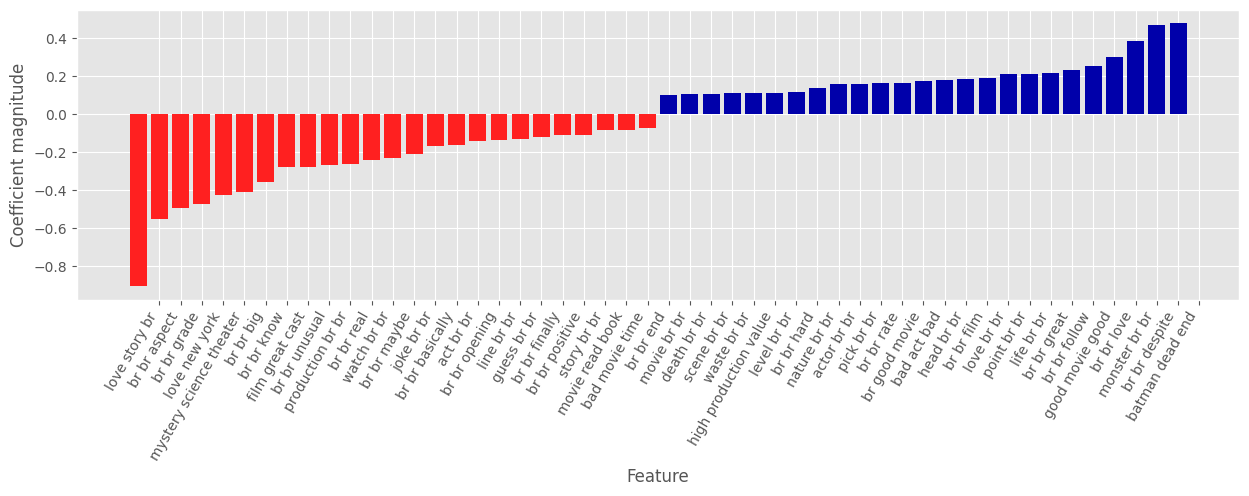

In [141]:
LR1.fit(CV.fit_transform(X), y)

# Get feature names from the current CountVectorizer
feature_names = np.array(CV.get_feature_names_out())

# Create a mask to filter for 3-gram features
mask = np.array([len(feature.split(" ")) == 3 for feature in feature_names])

# Get coefficients for all features
coef = LR1.coef_[0]

# Visualize only 3-gram features
mglearn.tools.visualize_coefficients(coef[mask], feature_names[mask], n_top_features=25)
plt.show()


In [1]:
print(len(coef.ravel()), len(feature_names))


NameError: name 'coef' is not defined

In [143]:
pwd

'/kaggle/working'

In [144]:
df.to_pickle("movie_reviews_CV_TF-IDF.pkl")

In [139]:


pd.set_option("display.max_colwidth", 200)


In [ ]:
import os

current_directory = os.getcwd()
print(current_directory)


[CV] END ............................................C=1e-05; total time=   0.3s
[CV] END .............................C=0.050010000000000006; total time=   0.5s
[CV] END .............................C=0.050010000000000006; total time=   0.4s
[CV] END ..........................................C=0.10001; total time=   0.5s
[CV] END ..............................C=0.15001000000000003; total time=   0.5s
[CV] END ..............................C=0.20001000000000002; total time=   0.5s
[CV] END ..........................................C=0.25001; total time=   0.5s
[CV] END ..........................................C=0.25001; total time=   0.6s
[CV] END ..............................C=0.30001000000000005; total time=   0.5s
[CV] END ..............................C=0.35001000000000004; total time=   0.5s
[CV] END ..............................C=0.40001000000000003; total time=   0.5s
[CV] END ..........................................C=0.45001; total time=   0.5s
[CV] END ...................

In [ ]:
import pandas as pd

df = pd.read_pickle("movie_reviews_CV_TF-IDF.pkl")


In [ ]:
df.head()

In [17]:
def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    return text

# Apply the cleaning function to the review column
df['cleaned_review'] = df['review'].apply(clean_text)


In [18]:
df.head()

,review,label,cleaned_review
0,? this film was just brilliant casting locatio...,1,this film was just brilliant casting location...
1,? big hair big boobs bad music and a giant saf...,0,big hair big boobs bad music and a giant safe...
2,? this has to be one of the worst films of the...,0,this has to be one of the worst films of the ...
3,? the ? ? at storytelling the traditional sort...,1,the at storytelling the traditional sort ma...
4,? worst mistake of my life br br i picked this...,0,worst mistake of my life br br i picked this ...


In [19]:
import spacy

# Load the English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")

# Example text
text = "SpaCy is an NLP library for Python. It's user-friendly and efficient."

# Process the text
doc = nlp(text)

# Tokenization
tokens = [token.text for token in doc]
print("Tokens:", tokens)

# Lemmatization, removing stopwords and punctuation
cleaned_text = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
print("Cleaned Text:", cleaned_text)


Tokens: ['SpaCy', 'is', 'an', 'NLP', 'library', 'for', 'Python', '.', 'It', "'s", 'user', '-', 'friendly', 'and', 'efficient', '.']
Cleaned Text: ['SpaCy', 'NLP', 'library', 'Python', 'user', 'friendly', 'efficient']


In [20]:
def spacy_cleaner(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

df['cleaned_review_spacy'] = df['review'].apply(spacy_cleaner)


In [ ]:
!pip install gensim


In [21]:
from gensim.models import Word2Vec

# Preparing data (list of tokenized sentences)
tokenized_data = [text.split() for text in df['cleaned_review_spacy']]

# Training a Word2Vec model
model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=1, workers=4)

# Example: Use the model to get the vector of a word
vector = model.wv['movie']
print("Vector for 'movie':", vector)

# Find similar words
similar_words = model.wv.most_similar('movie')
print("Words similar to 'movie':", similar_words)


Vector for 'movie': [-1.0630919   0.06428399 -0.6852242  -0.8163356   0.21243817 -0.66763055
  0.09169137  1.5275186  -0.971968   -0.44966403 -0.4806093   0.02894164
  0.6552046  -0.33902416  0.6900396   0.7716576   1.0737454   2.1216066
 -0.04171439 -0.54758096  0.6636099   0.29776958  1.3532175  -0.7191184
  1.1255748  -0.38087034  0.12238622 -0.17144878  0.5962835   0.2038106
  1.2856532  -1.2980222   0.88253844 -1.0595801  -0.1567273  -0.8274547
  1.3223175   1.5914918  -0.25762218  1.8661932  -0.18250065  0.03097843
 -1.4440279   0.4798299   0.62017155  0.8571969   0.07862401  0.8806433
  0.26187885 -0.23432283  0.1077904   0.2666134   1.0847392  -1.0223749
  0.92718357 -0.37328303  1.1333519   0.89567935 -0.21597165  1.9879965
 -0.12672862 -0.21293716  0.01955521 -0.311472    0.65933365  0.7827878
  0.66759366  0.8321551  -0.55554074 -0.15090881 -1.217419    0.67500687
  0.47144264  1.3015902  -0.3407353   0.05361623 -0.6886386   0.02673863
 -1.4663712  -0.54541445 -1.1688148   0

In [22]:
from keras.preprocessing.sequence import pad_sequences

# Pad the sequences to have the same length
maxlen = 100  # You can choose a different length
X_train = pad_sequences(train_data, maxlen=maxlen)
X_test = pad_sequences(test_data, maxlen=maxlen)


## 3. Build the LSTM Model

In [23]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Model definition
model = Sequential()
model.add(Embedding(10000, 128))  # 10,000 is the size of the vocabulary, 128 is the embedding dimension
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


## 4. Train the Model

In [5]:
history = model.fit(X_train, train_labels, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 73s 441ms/step - loss: 0.4507 - accuracy: 0.7815 - val_loss: 0.3526 - val_accuracy: 0.8482
Epoch 2/10
157/157 [==============================] - 67s 428ms/step - loss: 0.2672 - accuracy: 0.8947 - val_loss: 0.3578 - val_accuracy: 0.8492
Epoch 3/10
157/157 [==============================] - 67s 427ms/step - loss: 0.2002 - accuracy: 0.9244 - val_loss: 0.3619 - val_accuracy: 0.8428
Epoch 4/10
157/157 [==============================] - 67s 426ms/step - loss: 0.1443 - accuracy: 0.9488 - val_loss: 0.4606 - val_accuracy: 0.8386
Epoch 5/10
157/157 [==============================] - 68s 431ms/step - loss: 0.1124 - accuracy: 0.9602 - val_loss: 0.4555 - val_accuracy: 0.8324
Epoch 6/10
157/157 [==============================] - 67s 429ms/step - loss: 0.0823 - accuracy: 0.9728 - val_loss: 0.6064 - val_accuracy: 0.8276
Epoch 7/10
157/157 [==============================] - 68s 430ms/step - loss: 0.0610 - accuracy: 0.9798 - val_loss: 0.6729 - val_ac

##  Evaluate the Model

In [25]:
results = model.evaluate(X_test, test_labels)
print(f'Test Accuracy: {results[1]}')


782/782 [==============================] - 21s 27ms/step - loss: 0.9407 - accuracy: 0.8146
Test Accuracy: 0.8145999908447266


## Model Hyperparameters tuning  Example: Adjusting LSTM Units and Dropout

In [32]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# Adjusting these variables
n_lstm_units = 256  # Number of LSTM units
dropout_rate = 0.3  # Dropout rate

# Define model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128))
model.add(LSTM(n_lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, train_labels, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
625/625 [==============================] - 249s 393ms/step - loss: 0.4517 - accuracy: 0.7813 - val_loss: 0.3540 - val_accuracy: 0.8482
Epoch 2/10
625/625 [==============================] - 246s 394ms/step - loss: 0.2816 - accuracy: 0.8874 - val_loss: 0.3571 - val_accuracy: 0.8474
Epoch 3/10
625/625 [==============================] - 256s 409ms/step - loss: 0.1922 - accuracy: 0.9265 - val_loss: 0.3830 - val_accuracy: 0.8442
Epoch 4/10
625/625 [==============================] - 244s 391ms/step - loss: 0.1385 - accuracy: 0.9507 - val_loss: 0.4633 - val_accuracy: 0.8360
Epoch 5/10
625/625 [==============================] - 245s 392ms/step - loss: 0.1069 - accuracy: 0.9631 - val_loss: 0.5427 - val_accuracy: 0.8330
Epoch 6/10
625/625 [==============================] - 245s 393ms/step - loss: 0.0778 - accuracy: 0.9743 - val_loss: 0.5561 - val_accuracy: 0.8244
Epoch 7/10
625/625 [==============================] - 245s 391ms/step - loss: 0.0676 - accuracy: 0.9779 - val_loss: 0.6941 -

In [34]:
# Generate predictions
predictions = model.predict(X_test)
predictions = [1 if p > 0.5 else 0 for p in predictions]


782/782 [==============================] - 56s 70ms/step


In [33]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, test_labels)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


782/782 [==============================] - 55s 71ms/step - loss: 0.8176 - accuracy: 0.8238
Test Loss: 0.8175938129425049
Test Accuracy: 0.8238400220870972


## save model

In [26]:
model.save('my_model.h5')  # saves the model


## Save the Evaluation Results

In [27]:
results = model.evaluate(X_test, test_labels)
print(f'Test Accuracy: {results[1]}')

# Save the results to a text file
with open('model_evaluation.txt', 'w') as file:
    file.write(f'Test Loss: {results[0]}\n')
    file.write(f'Test Accuracy: {results[1]}\n')


782/782 [==============================] - 20s 26ms/step - loss: 0.6932 - accuracy: 0.5008
Test Accuracy: 0.5008000135421753


## Load the Model

In [30]:
from keras.models import load_model

# Load the model
loaded_model = load_model('my_model.h5')

# You can now use loaded_model to make predictions or evaluate it further


## Web Application Example with Flask

In [31]:
from flask import Flask, request, jsonify
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences


app = Flask(__name__)

# Load the model
model = load_model('my_lstm_model.h5')

@app.route('/predict', methods=['POST'])
def predict():
    # Get data from Post request
    data = request.json
    review = data['review']

    # Preprocess the review (tokenization, padding)
    # Assuming tokenizer is already fitted and saved
    # tokenizer = ...
    sequences = tokenizer.texts_to_sequences([review])
    padded_sequences = pad_sequences(sequences, maxlen=100)  # Assuming maxlen=100 was used during training

    # Predict
    prediction = model.predict(padded_sequences)
    response = {'prediction': 'positive' if prediction[0][0] > 0.5 else 'negative'}

    return jsonify(response)

if __name__ == '__main__':
    app.run(debug=True)


OSError: No file or directory found at my_lstm_model.h5

## Lemmatization in Spacy